In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [2]:
def getGradient(gray, x = 0, y = 0, useGradient = True):
    if useGradient:
        grad = cv2.Sobel(gray, ddepth=cv2.CV_32F, dx=x, dy=y, ksize=3)
        grad = np.absolute(grad)
        (minVal, maxVal) = (np.min(grad), np.max(grad)) 
        if maxVal - minVal > 0:
            grad = (255 * ((grad - minVal) / float(maxVal - minVal))).astype("uint8")
        else:
            grad  = np.zeros(gray.shape, dtype = "uint8")

    else:
        grad = cv2.adaptiveThreshold(gray, 255,
                                     cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                     cv2.THRESH_BINARY_INV, 11, 2)
    return grad

In [3]:
def show_img(img, w = 20, h = 20):
    fig, ax = plt.subplots(figsize=(w, h))
    ax.imshow(img, cmap='gray')
    plt.show()

In [4]:
datasetInfo = []
imageCol = []

In [11]:
with open('input_seg.txt') as input_coords:
    lines = input_coords.readlines()
    for idx in range(0, len(lines), 2):
        name, coords = lines[idx: idx + 2]
        datasetInfo.append([name.strip(), coords.split()])

In [12]:
for item in datasetInfo:
    path = '{}'.format(item[0])
    x1, y1, x2, y2 = map(int, item[1])
    image = cv2.imread(path)[x1:x2, y1:y2]
    imageCol.append(image)

## Tools

In [13]:
import math

def concat_hor(imgs, color = (0,255,0)):
    m = 0
    s = 0
    bs = 1
    for img in imgs:
        m = max(m, img.shape[0])
        s += img.shape[1]+2*bs


    image = np.zeros((m+2*bs, s, 3))

    x = 0
    for img in imgs:
        if len(img.shape) == 3:
            imgg = cv2.copyMakeBorder(img.copy(), bs, bs, bs, bs, cv2.BORDER_CONSTANT, value=color)
            image[0:imgg.shape[0], x:x+imgg.shape[1], :] = imgg
        else:
            imgg = cv2.copyMakeBorder(cv2.cvtColor(img, cv2.COLOR_GRAY2BGR), bs, bs, bs, bs, cv2.BORDER_CONSTANT, value=color)
            image[0:imgg.shape[0], x:x+imgg.shape[1], :] = imgg
        x += img.shape[1]+2*bs

    return np.asarray(image, dtype = np.uint8)


def concat_ver(imgs):
    m = 0
    s = 0
    bs = 1
    for img in imgs:
        m = max(m, img.shape[1])
        s += img.shape[0]+2*bs


    image = np.zeros((s, m+2*bs, 3))

    y = 0
    for img in imgs:
        if len(img.shape) == 3:
            imgg = cv2.copyMakeBorder(img.copy(), bs, bs, bs, bs, cv2.BORDER_CONSTANT, value=(0, 255, 0))
            image[y:y+imgg.shape[0], 0:imgg.shape[1], :] = imgg
        else:
            imgg = cv2.copyMakeBorder(cv2.cvtColor(img, cv2.COLOR_GRAY2BGR), bs, bs, bs, bs, cv2.BORDER_CONSTANT, value=(0, 255, 0))
            image[y:y+imgg.shape[0], 0:imgg.shape[1], :] = imgg
        y += img.shape[0]+2*bs

    return np.asarray(image, dtype = np.uint8)


def getDrawProjectionVer(lp, verp):
    verp2 = verp.astype(int)
    w = np.max(verp2) + 5
    graphicVer = np.zeros((lp.shape[0], w), dtype = "uint8")

    for i in range(len(verp2)):
        graphicVer[i, 0:verp2[i]] = 255

    return cv2.cvtColor(graphicVer, cv2.COLOR_GRAY2BGR)


def getDrawProjectionHor(lp, horp):
    horp2 = horp.astype(int)
    h = int(np.max(horp2) + 5)
    graphicHor = np.zeros((h, lp.shape[1]), dtype = "uint8")

    for i in range(len(horp2)):
        graphicHor[int(graphicHor.shape[0]-horp2[i]):graphicHor.shape[0], i] = 255

    return cv2.cvtColor(graphicHor, cv2.COLOR_GRAY2BGR)


def findb0(verpConvolved, ybm, c):
    for i in range(ybm,-1,-1):
        if verpConvolved[i] <= c:
            return i
    return 0


def findb1(verpConvolved, ybm, c):
    for i in range(ybm,len(verpConvolved)):
        if verpConvolved[i] <= c:
            return i
    return len(verpConvolved)


def getHOGFeatures(img):  
    win_size = (48, 48)
    nbins = 4  # number of orientation bins
    cell = (5,5)  # h x w in pixels

    hog_temp = cv2.HOGDescriptor(_winSize=(win_size[0], win_size[1]),
                                _blockSize=(win_size[0], win_size[1]),
                                _blockStride=(cell[1], cell[0]),
                                _cellSize=(cell[1], cell[0]),
                                _nbins=nbins, _histogramNormType = 0, _gammaCorrection = True)

In [21]:
def horizontal_segmentation(img):
#     show_img(img)
    img_bin = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_bin = cv2.adaptiveThreshold(img_bin, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)
    img_bin = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, np.ones((3, 3), np.uint8))
#     show_img(img_bin)
    horVals = np.sum(img_bin, axis=0) / 255
    horProj = getDrawProjectionHor(img_bin, horVals)
#     show_img(horProj)
    kernel = np.array([-1, 3, 7, 3, -1]) / 11
    horConv = np.convolve(horVals, kernel, mode='same')
    horProjConv = getDrawProjectionHor(img_bin, horConv)
#     show_img(horProjConv)
    threshVal = np.min(horConv)
    print(threshVal)
    medianWidth = int(img.shape[0] * 0.3)
    bandP1rangesH = []
    peaksH = []
    c1, c2 = 0.09, 0.12
    while np.max(horConv) > 0:
        ybm = np.argmax(horConv)
        yb0 = findb0(horConv, ybm, c1 * horConv[ybm])
        yb1 = findb1(horConv, ybm, c2 * horConv[ybm])
        if yb1 - yb0 > medianWidth:
            bandP1rangesH.append((yb0, yb1))
            peaksH.append((int(horConv[ybm]), ybm))
        horConv[yb0:yb1] = 0
    wordBand = img.copy()
    bandRanges = sorted([item for t in bandP1rangesH for item in t])
    bandRanges_ = [0]
    for band in bandRanges:
        if band - bandRanges_[-1] <= 0.7 * medianWidth:
            bandRanges_[-1] = (band + bandRanges_[-1]) // 2
        elif band - bandRanges_[-1] <= 1.4 * medianWidth:
            bandRanges_[-1] = bandRanges_[-1]
        else:
            bandRanges_.append(band)
    for band in bandRanges_:
        wordBand = cv2.line(wordBand, (band, 0), (band, wordBand.shape[0]), (0, 255, 0), 1)
    show_img(wordBand)
    bandRanges_ = [0] + bandRanges_ + [img.shape[1]]
    return bandRanges_

-1.1818181818181819


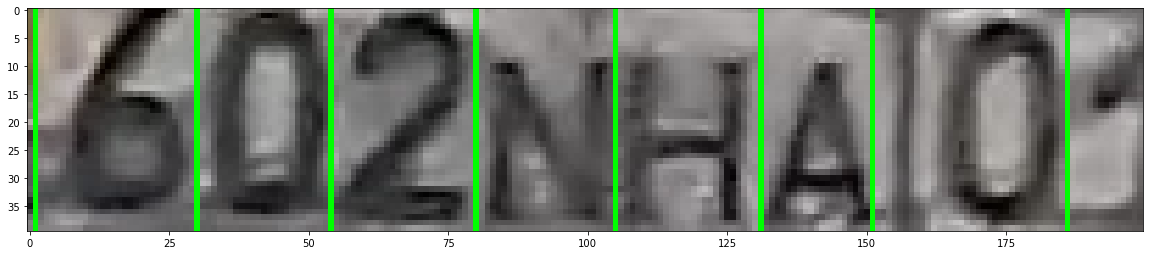

[0, 1, 30, 54, 80, 105, 131, 151, 186, 200]

In [22]:
horizontal_segmentation(imageCol[2])

-1.9090909090909092


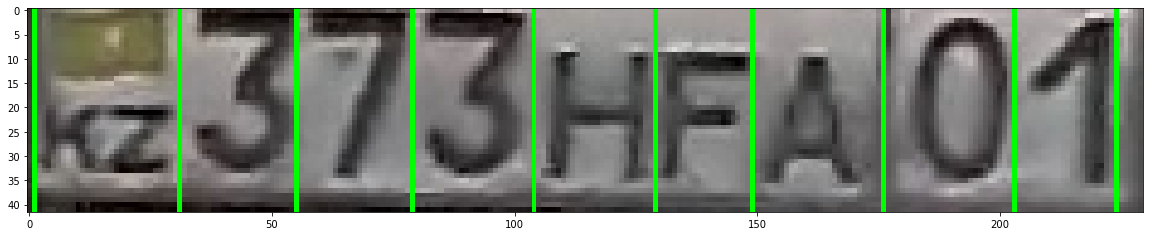

-2.5454545454545454


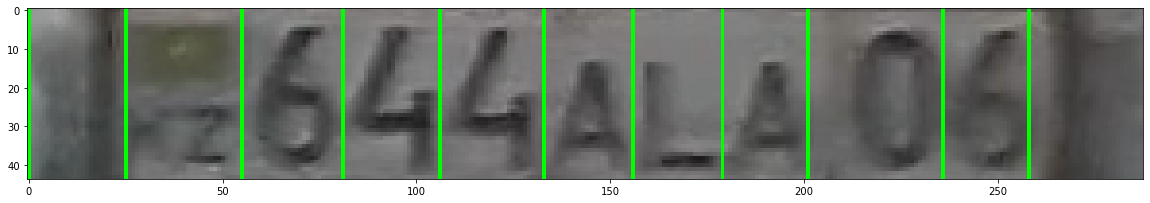

-1.1818181818181819


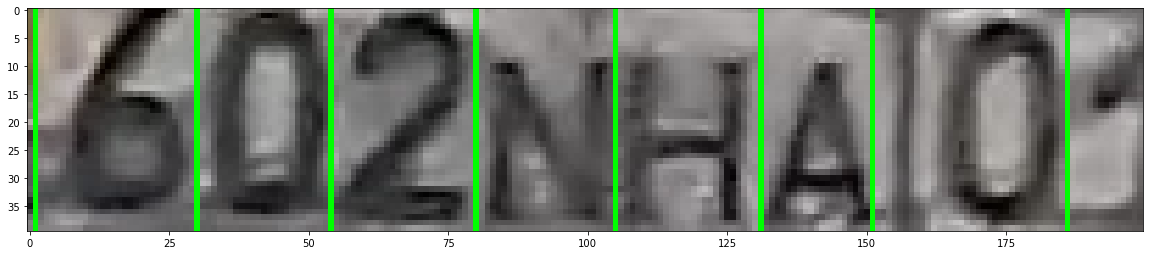

-2.4545454545454546


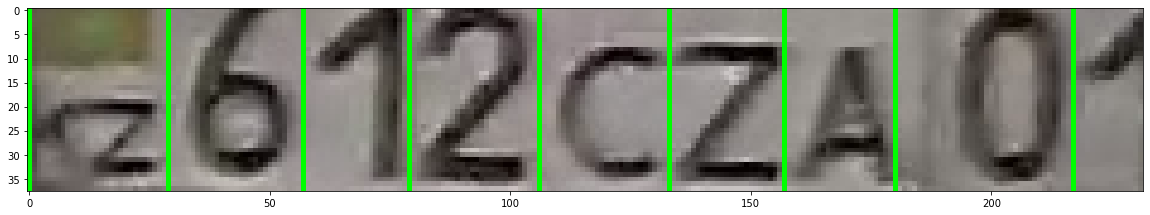

-1.7272727272727275


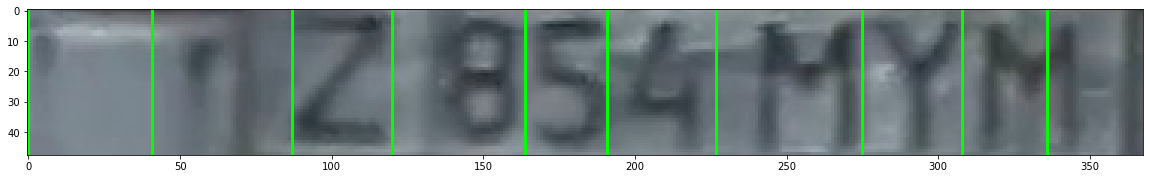

-1.1818181818181817


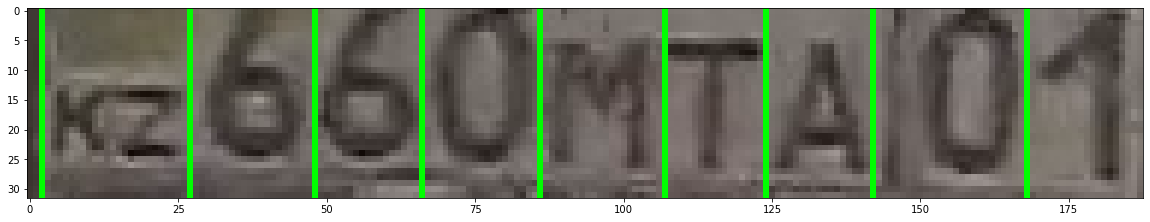

-3.7272727272727275


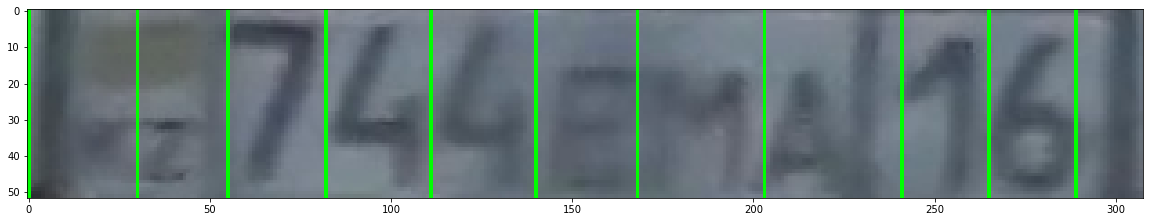

-2.0


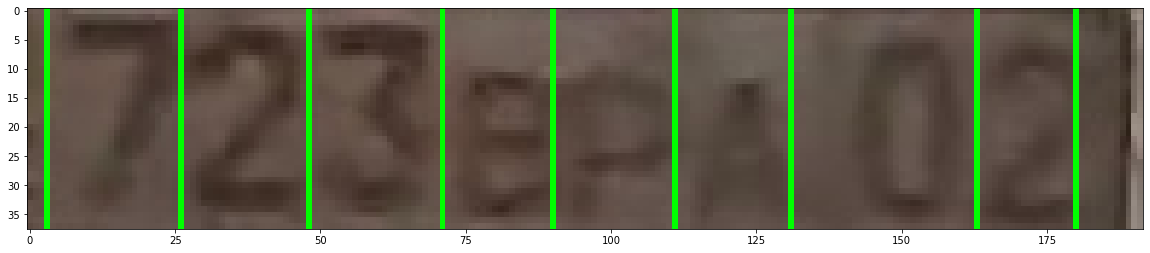

-1.3636363636363635


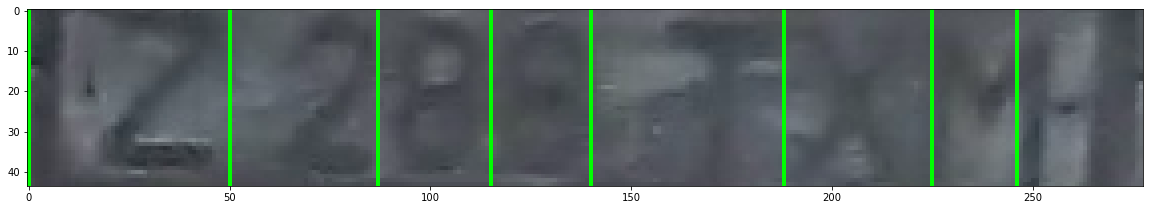

-2.727272727272727


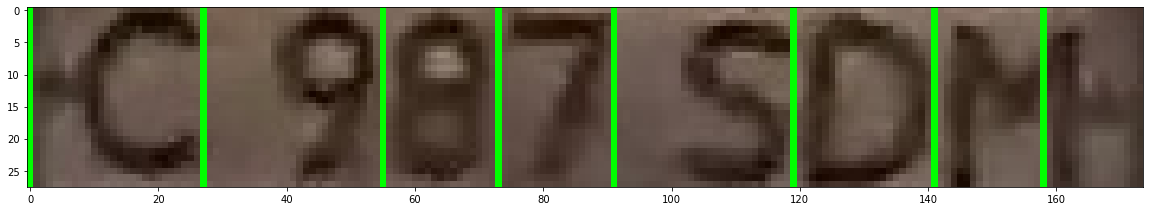

-2.909090909090909


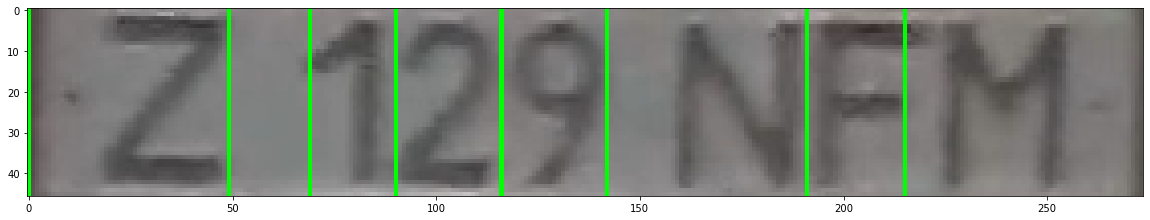

-2.5454545454545454


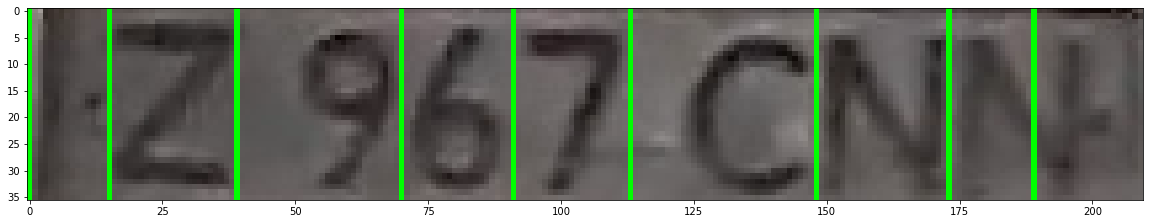

-2.1818181818181817


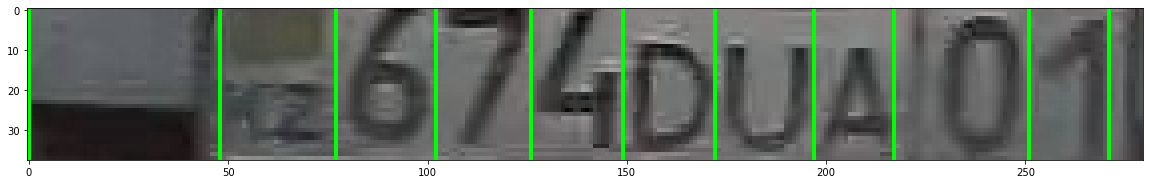

-2.3636363636363638


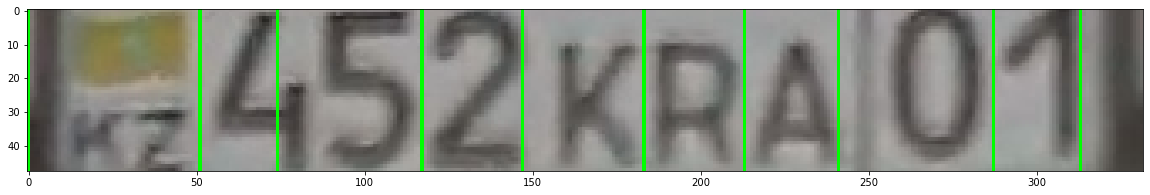

-2.4545454545454546


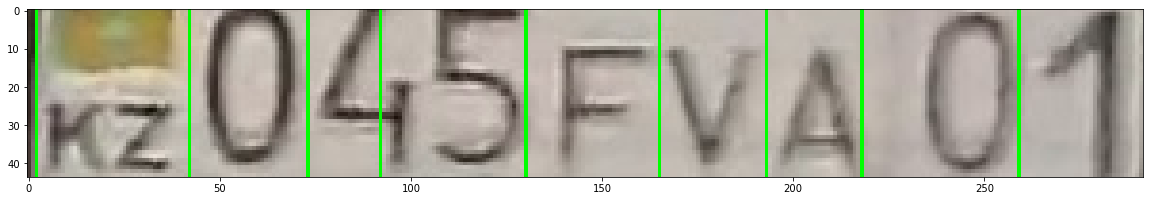

-2.1818181818181817


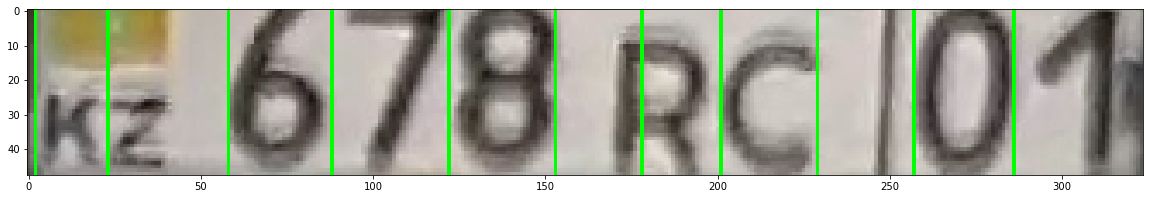

-3.8181818181818183


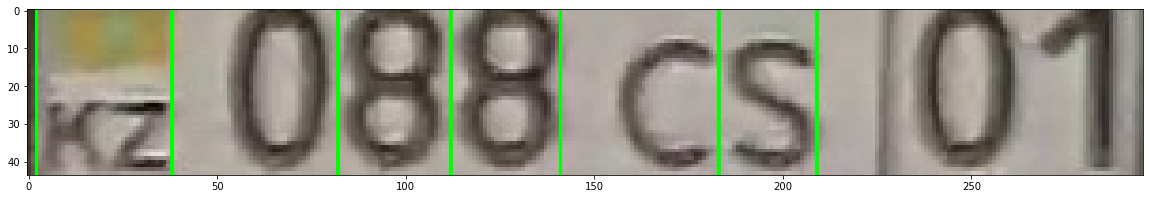

-2.0


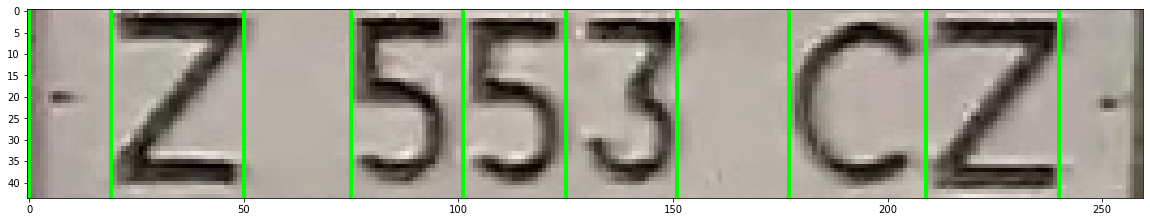

-1.9090909090909094


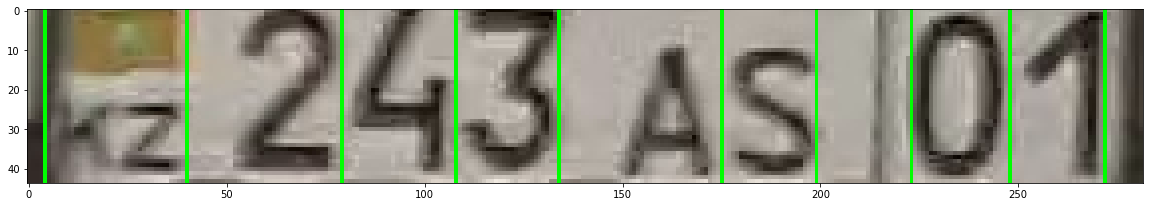

-2.7272727272727275


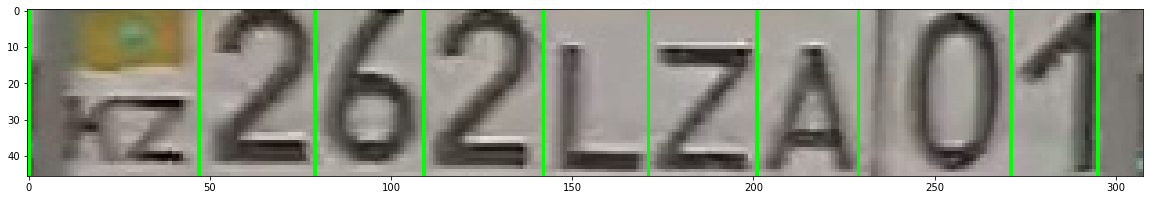

-2.1818181818181817


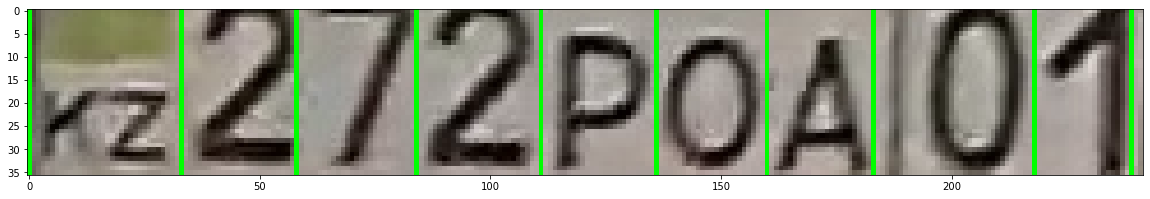

-2.090909090909091


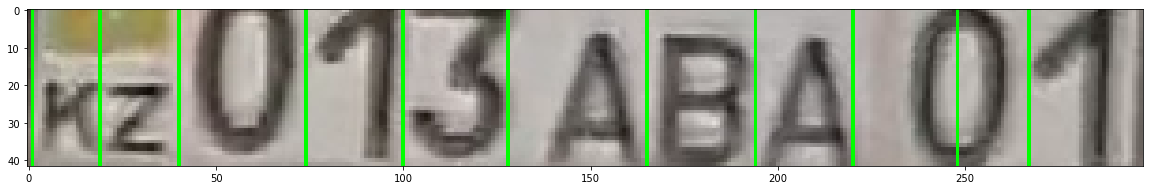

-3.909090909090909


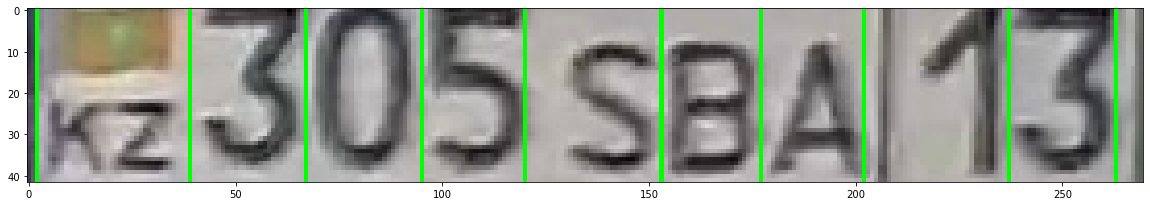

-3.8181818181818183


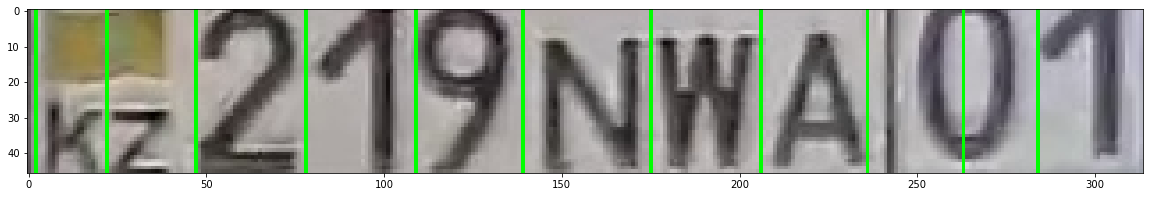

-2.454545454545454


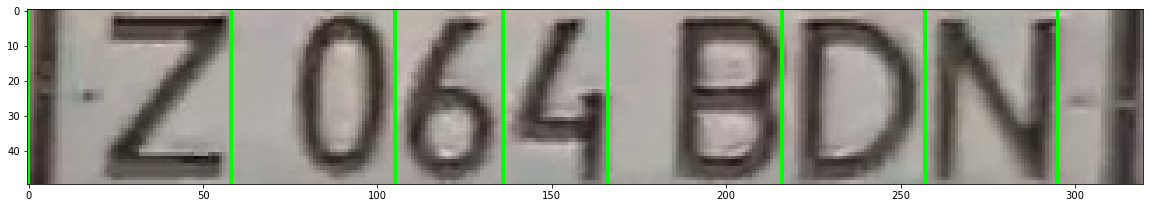

-3.5454545454545454


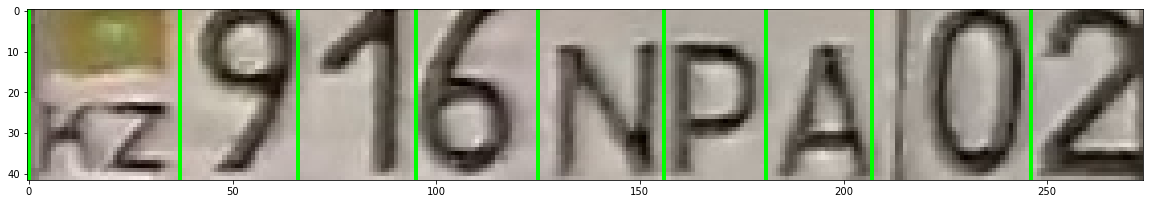

-2.4545454545454546


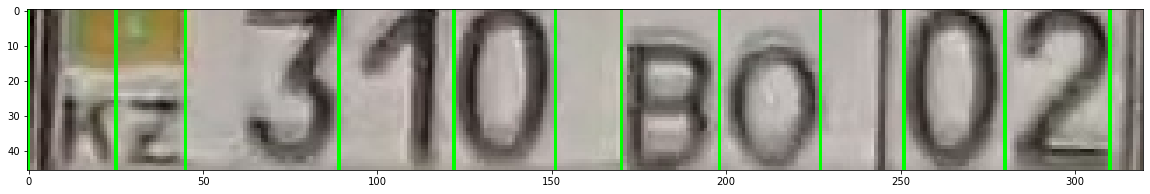

-2.7272727272727275


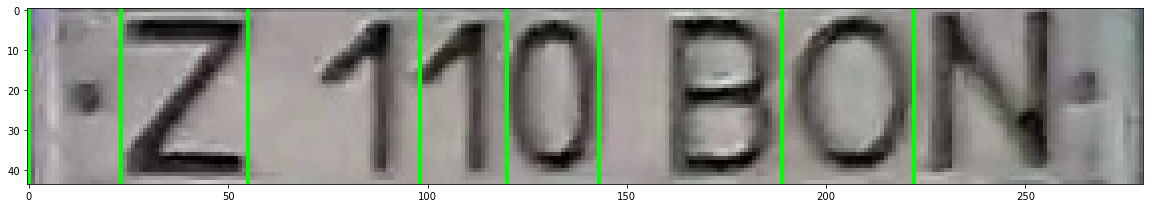

-1.9090909090909092


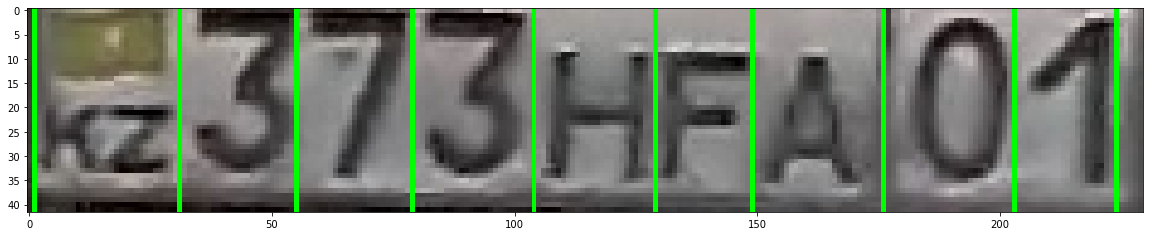

-2.5454545454545454


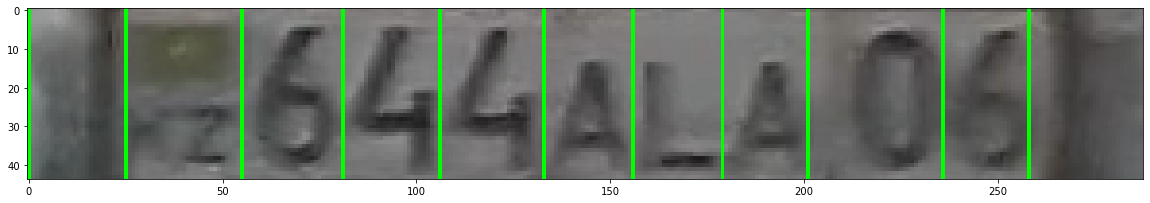

-1.1818181818181819


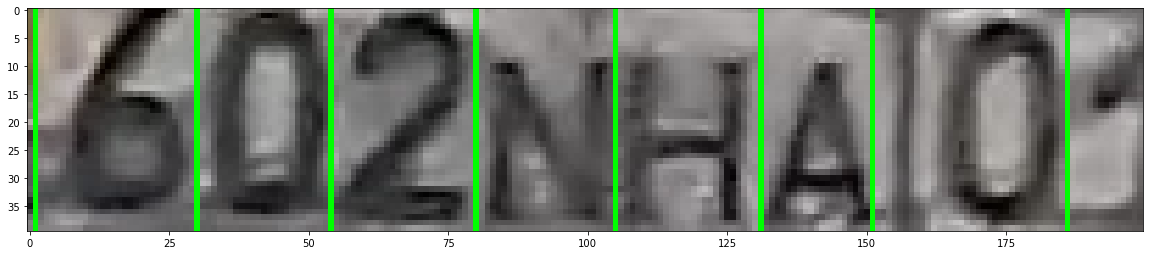

-2.4545454545454546


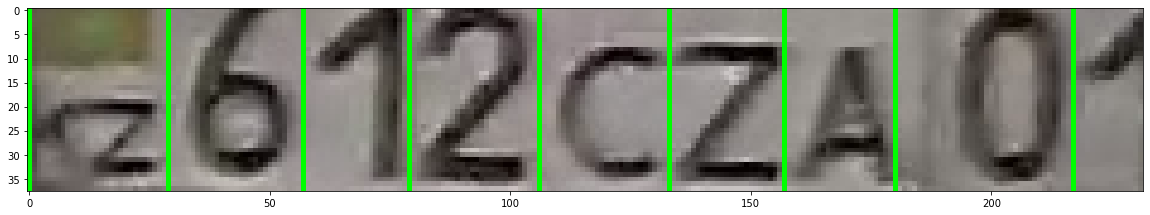

-1.7272727272727275


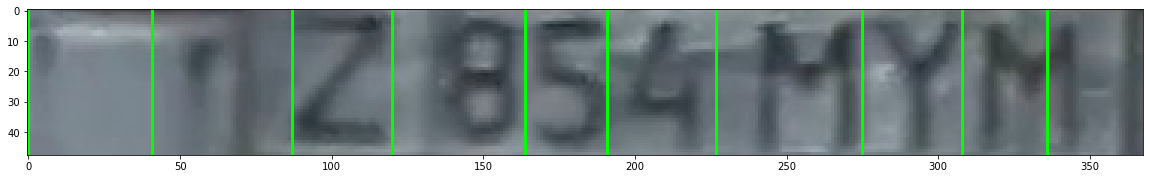

-1.1818181818181817


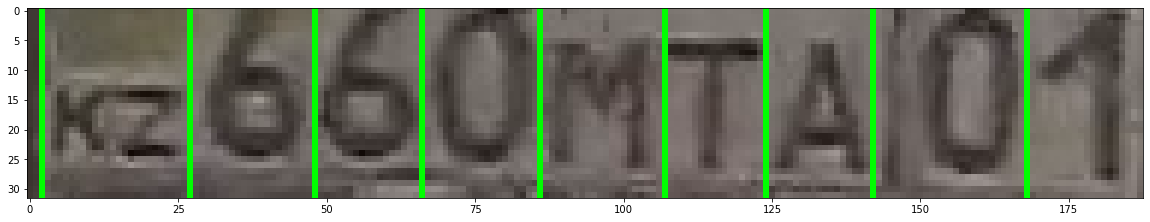

-3.7272727272727275


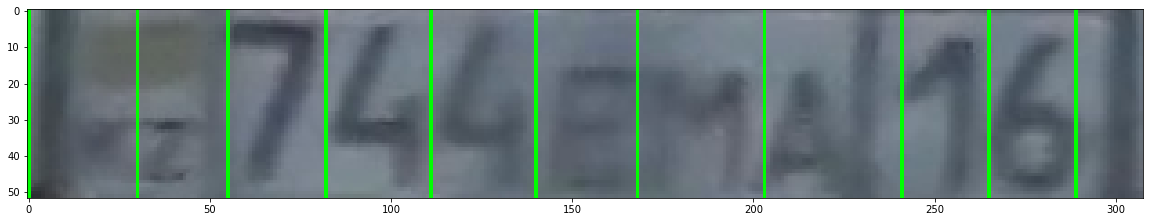

-2.0


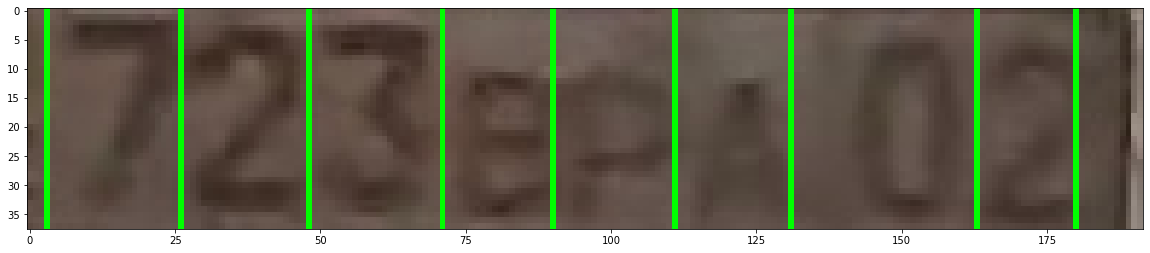

-1.3636363636363635


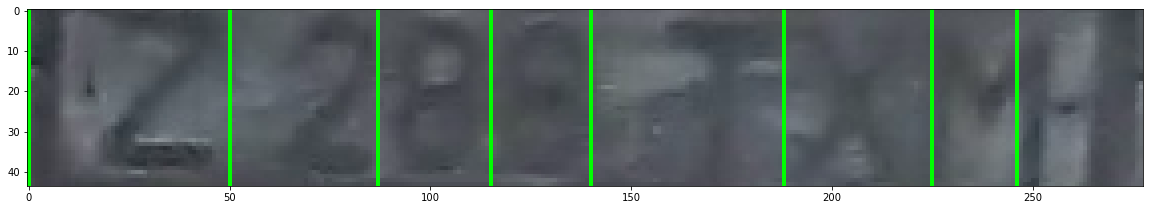

-2.727272727272727


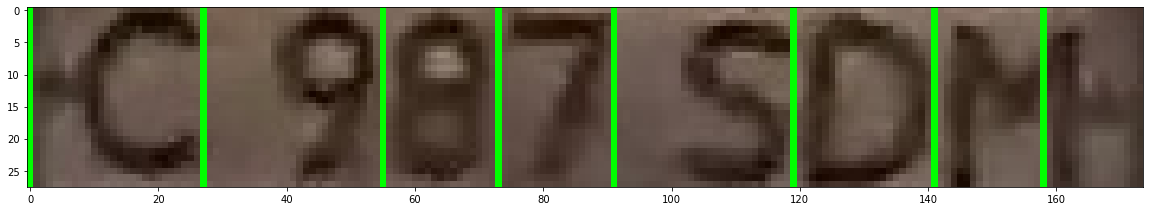

-2.909090909090909


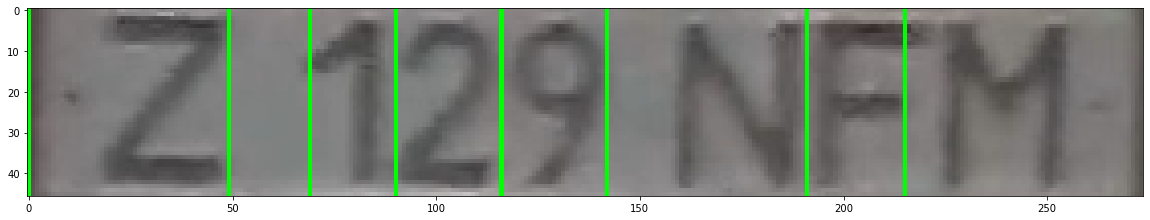

-2.5454545454545454


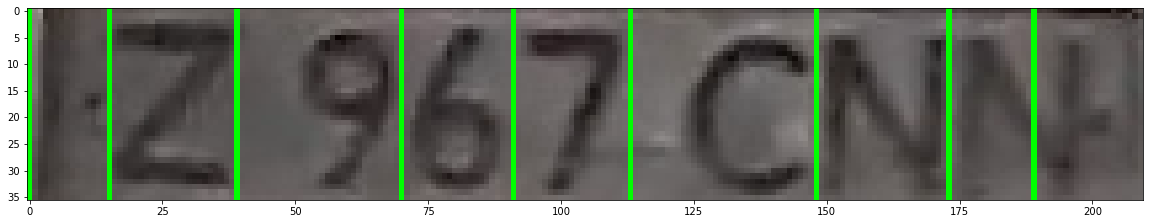

-2.1818181818181817


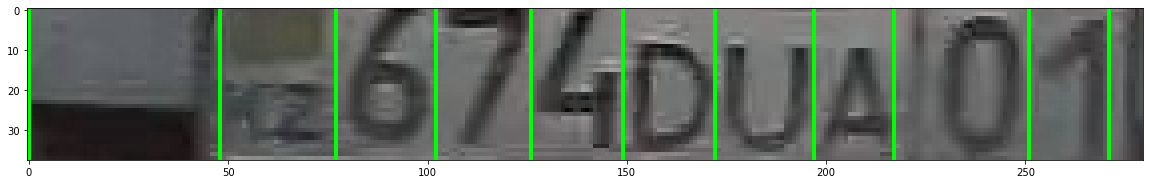

-2.3636363636363638


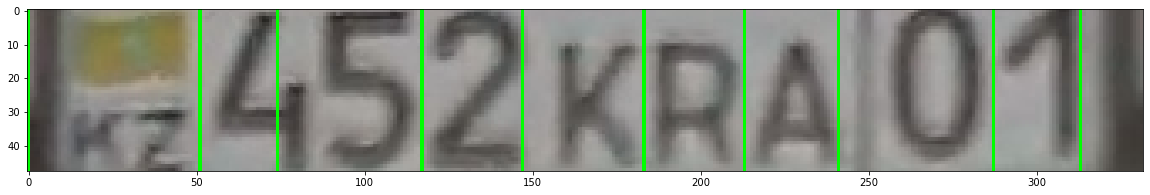

-2.4545454545454546


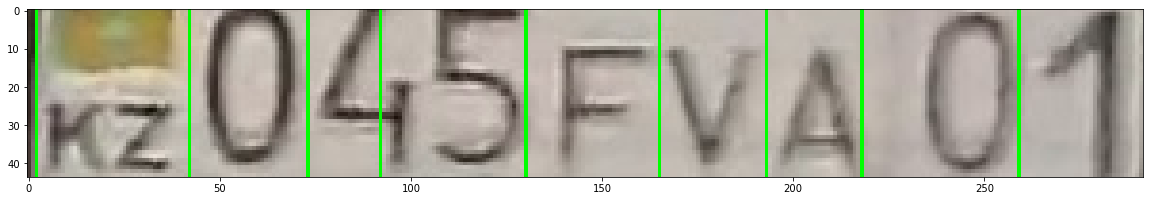

-2.1818181818181817


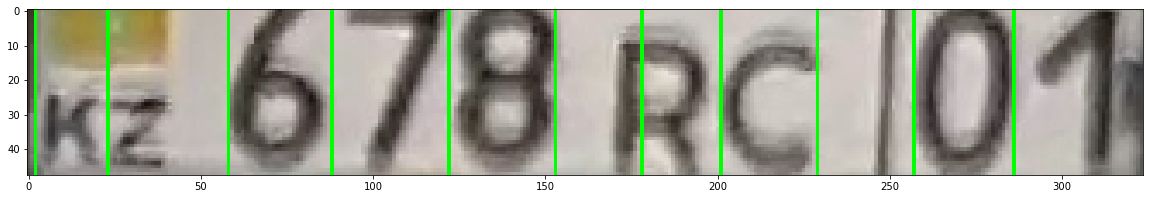

-3.8181818181818183


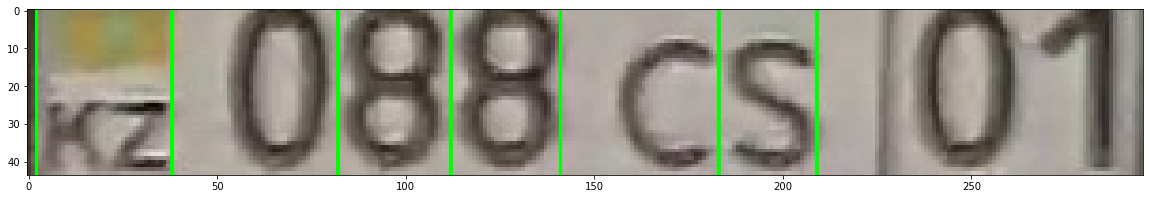

-2.0


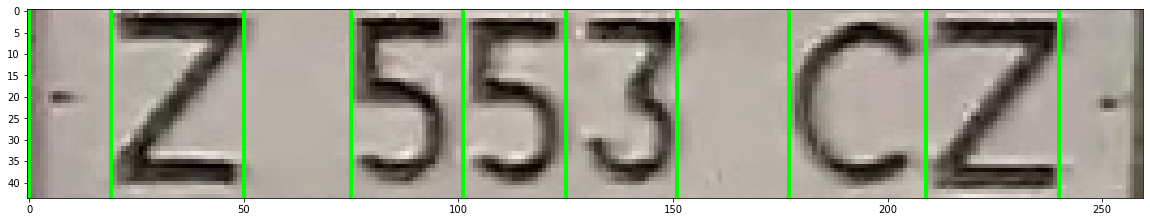

-1.9090909090909094


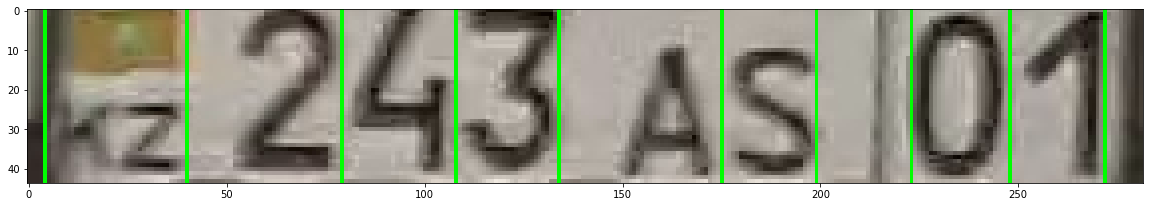

-2.7272727272727275


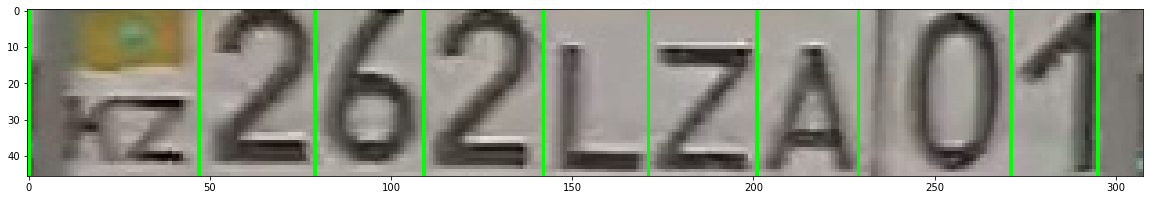

-2.1818181818181817


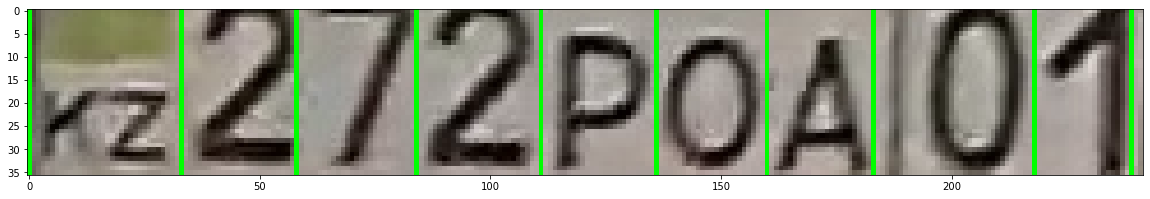

-2.090909090909091


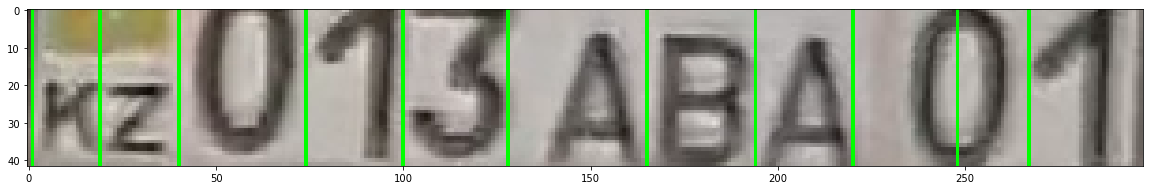

-3.909090909090909


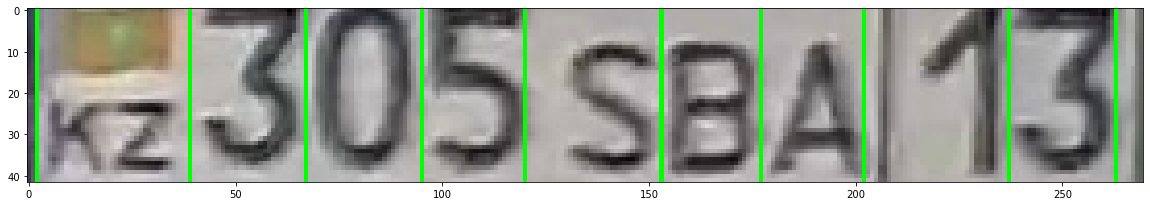

-3.8181818181818183


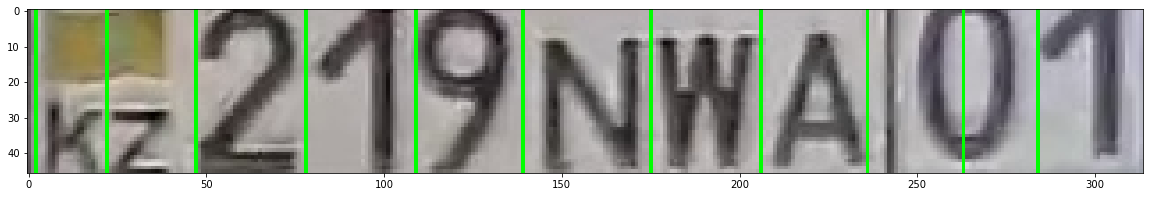

-2.454545454545454


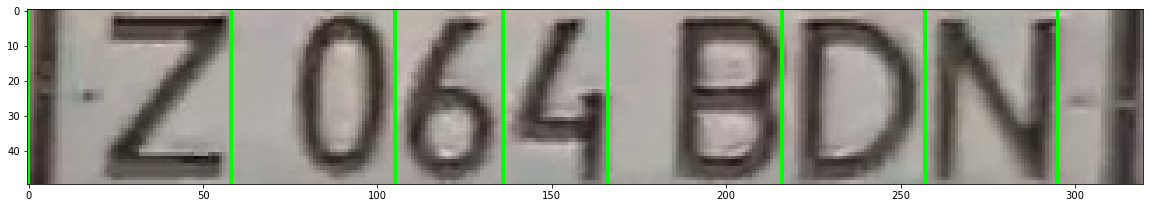

-3.5454545454545454


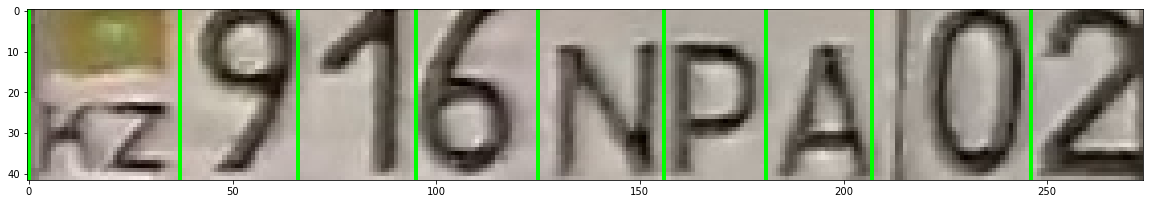

-2.4545454545454546


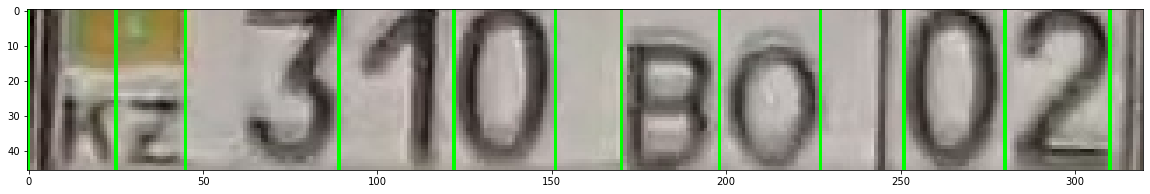

-2.7272727272727275


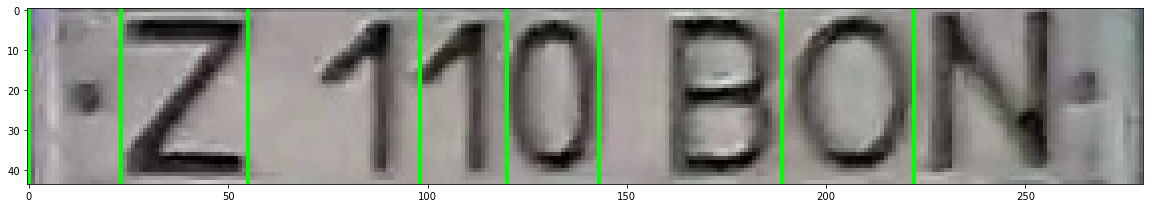

-1.9090909090909092


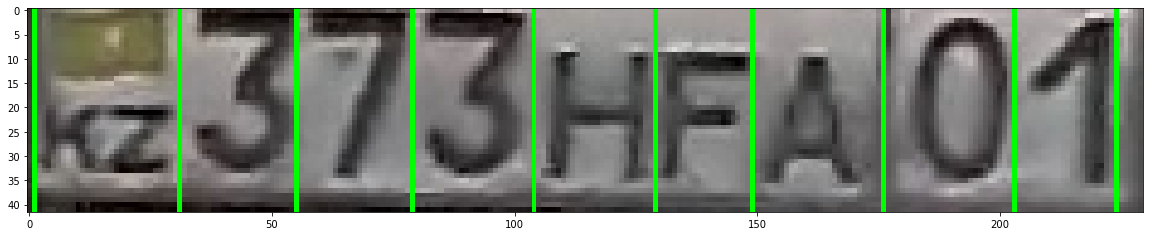

-2.5454545454545454


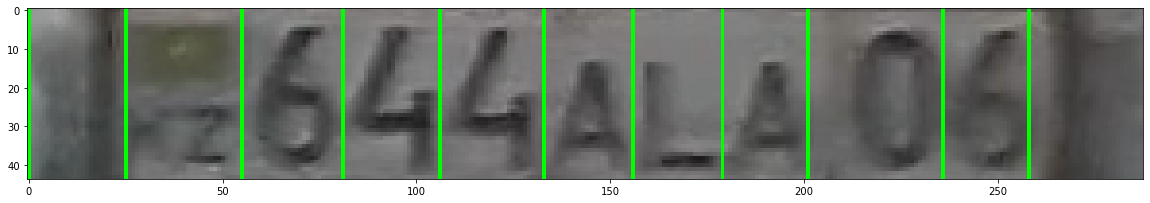

-1.1818181818181819


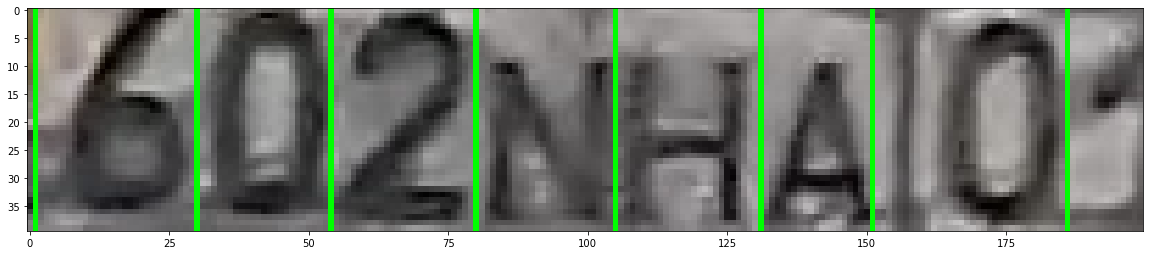

-2.4545454545454546


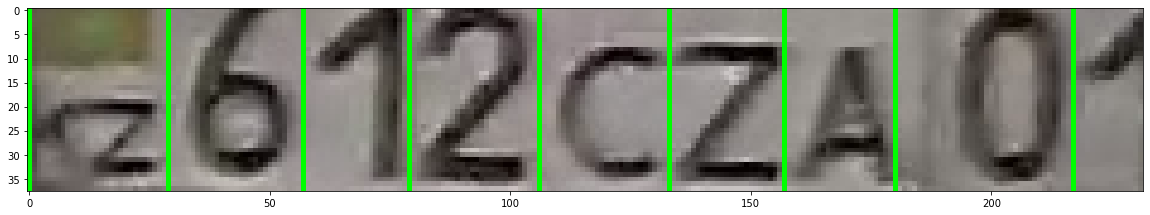

-1.7272727272727275


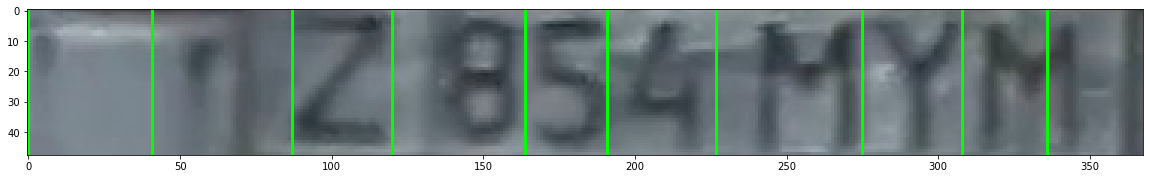

-1.1818181818181817


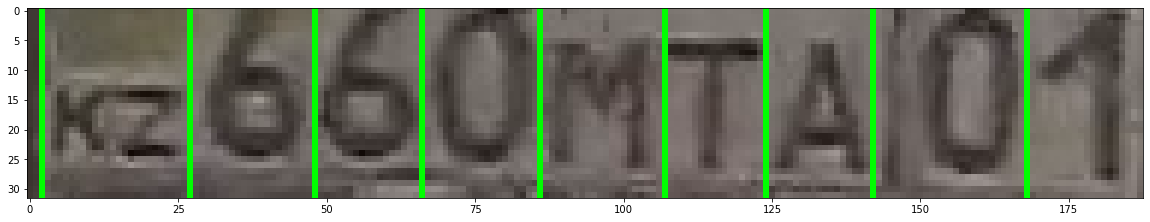

-3.7272727272727275


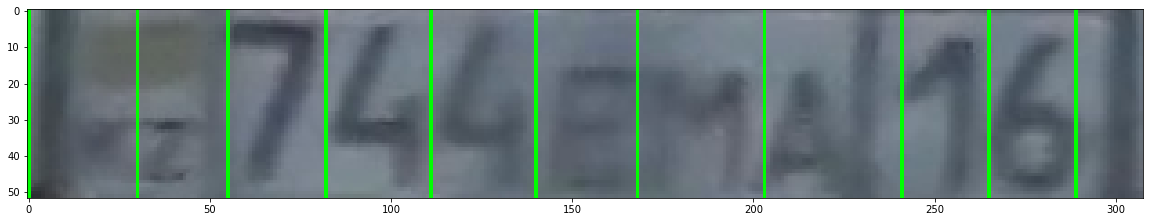

-2.0


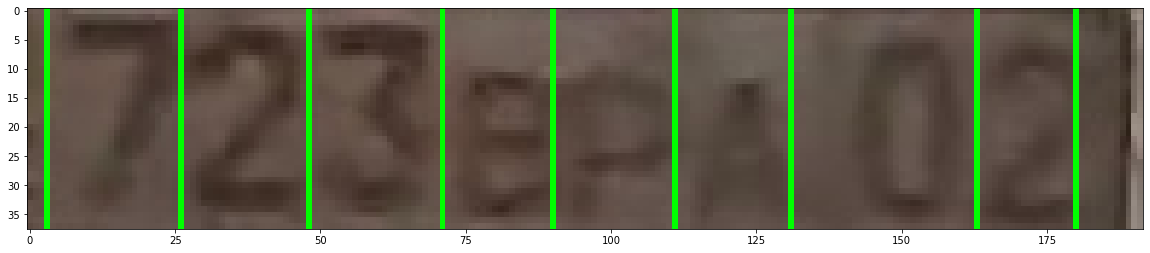

-1.3636363636363635


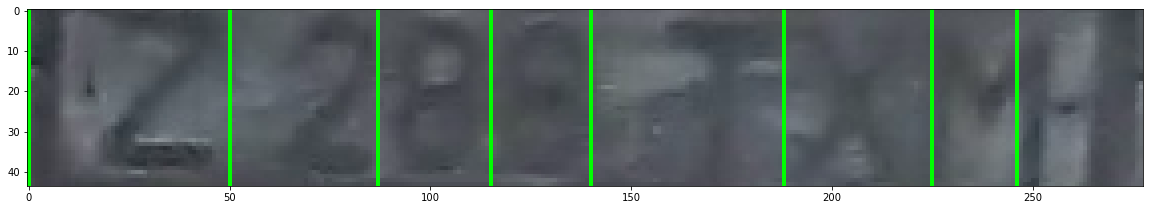

-2.727272727272727


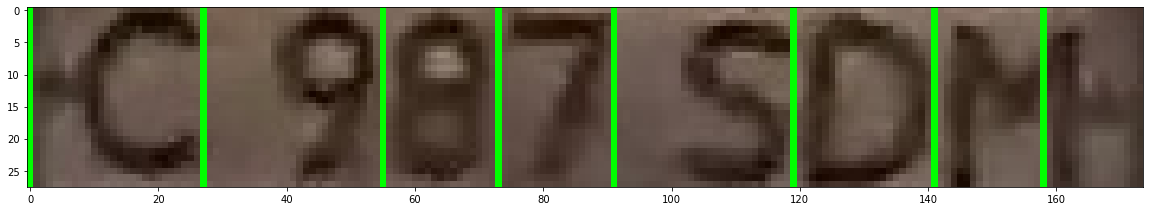

-2.909090909090909


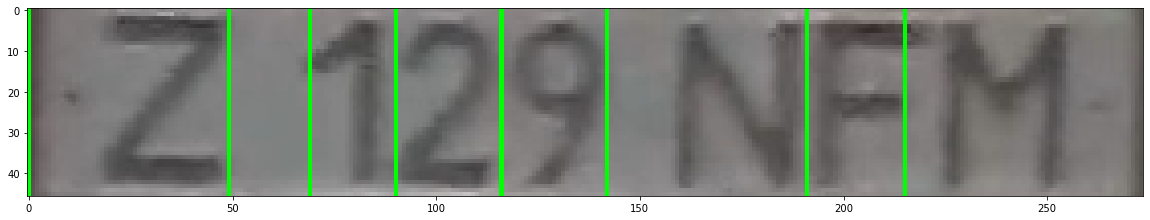

-2.5454545454545454


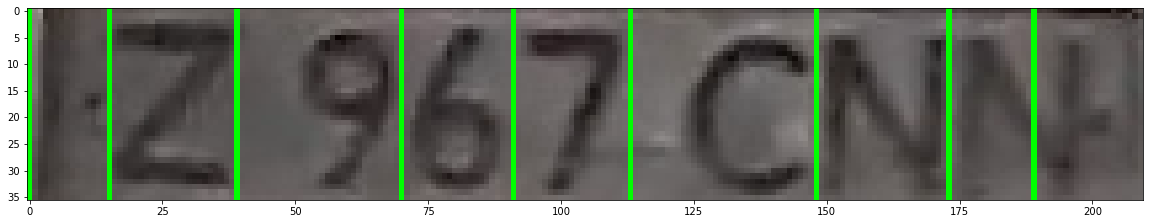

-2.1818181818181817


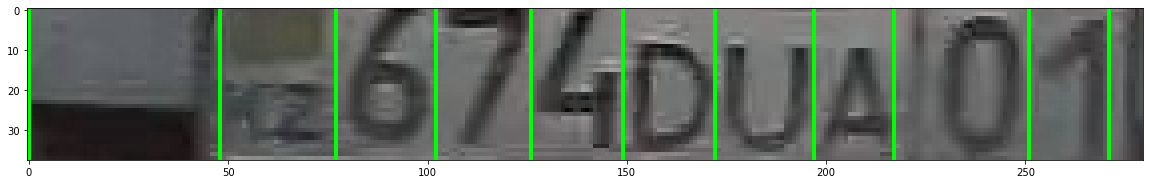

-2.3636363636363638


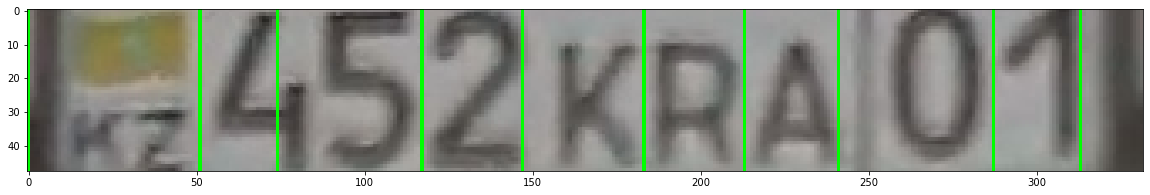

-2.4545454545454546


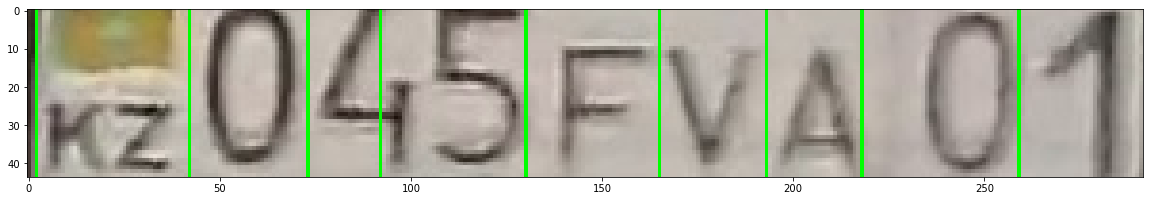

-2.1818181818181817


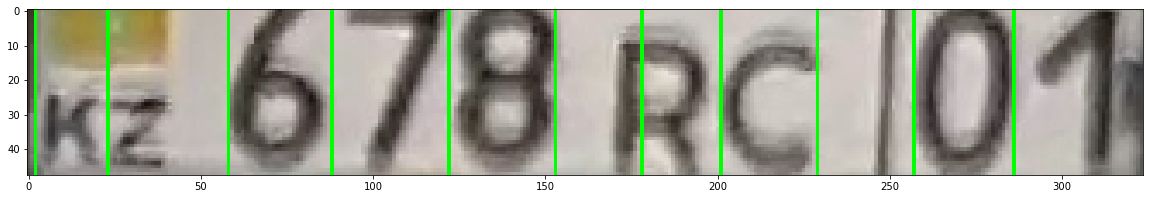

-3.8181818181818183


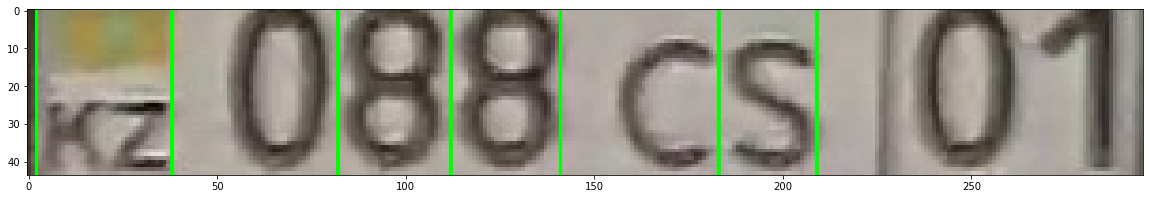

-2.0


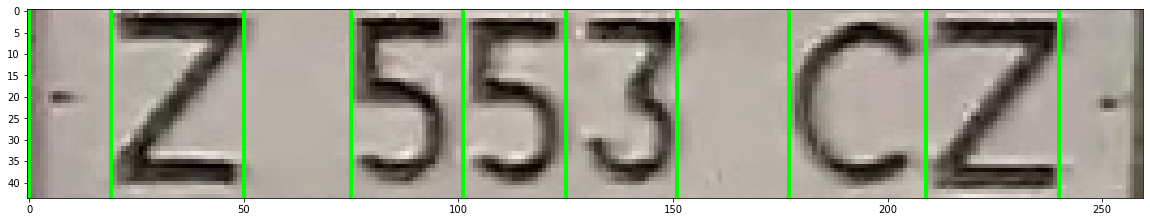

-1.9090909090909094


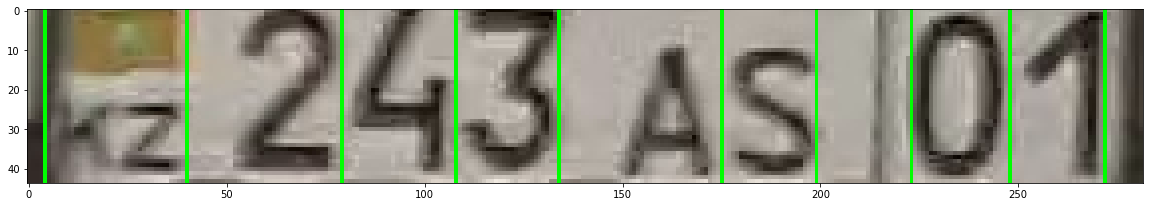

-2.7272727272727275


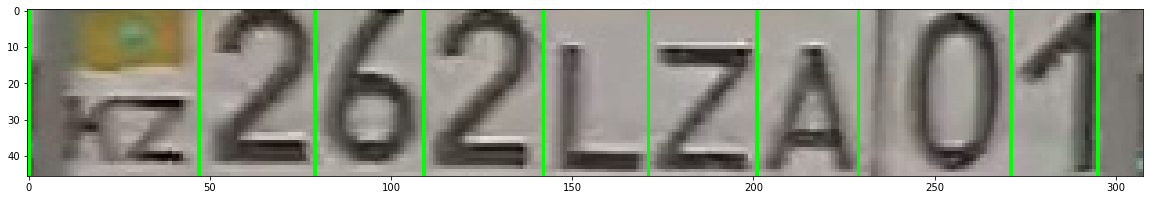

-2.1818181818181817


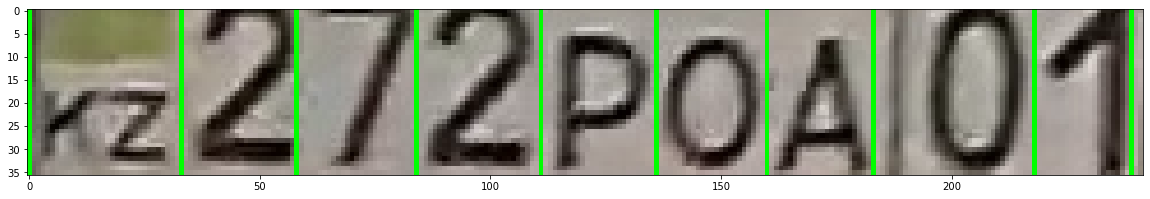

-2.090909090909091


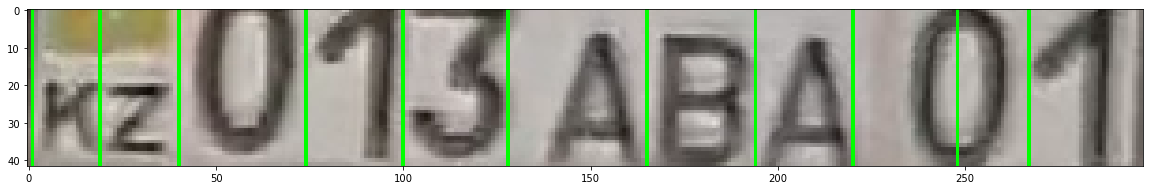

-3.909090909090909


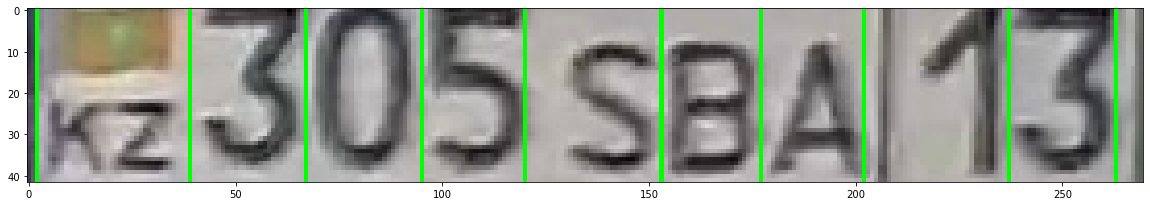

-3.8181818181818183


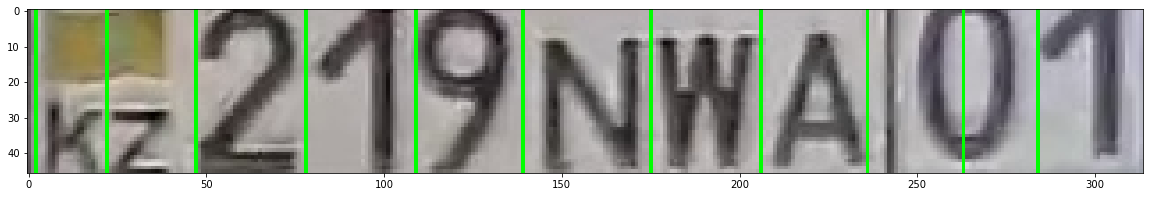

-2.454545454545454


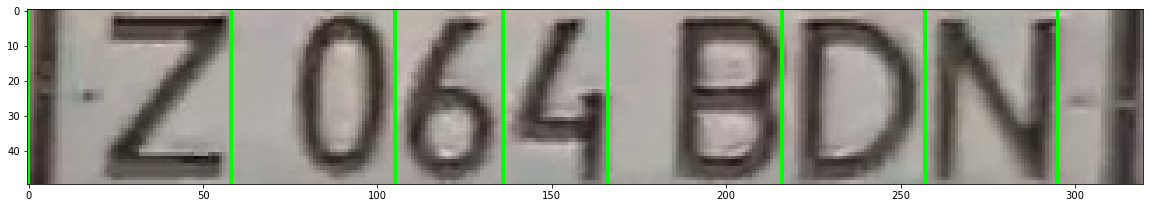

-3.5454545454545454


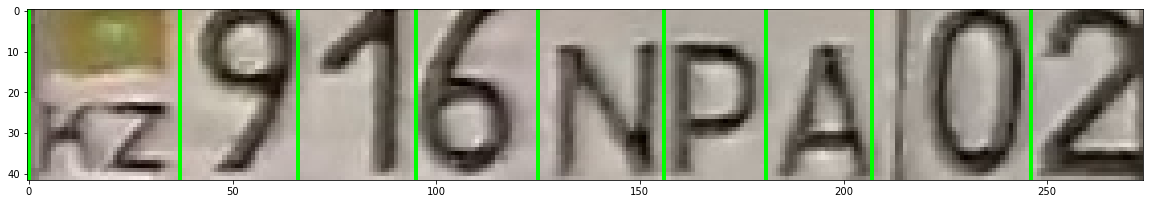

-2.4545454545454546


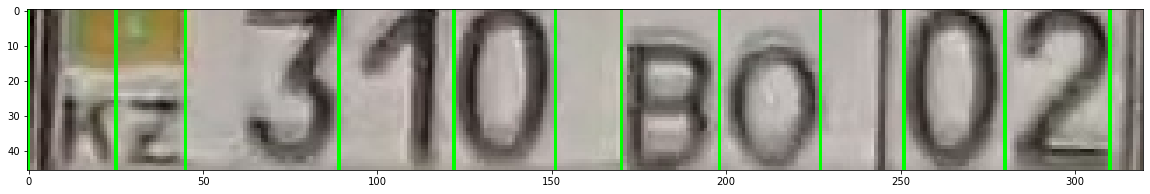

-2.7272727272727275


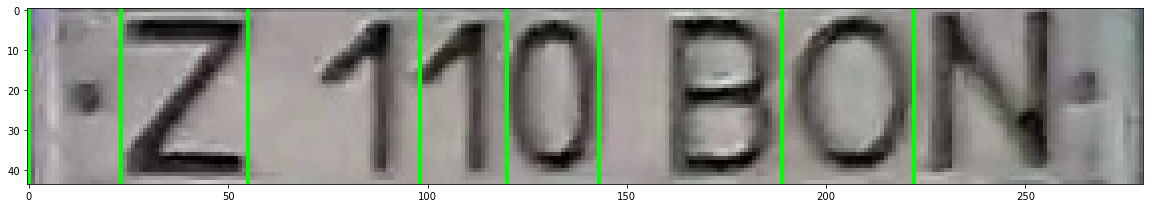

In [23]:
for image in imageCol:
    horizontal_segmentation(image)

In [24]:
datasetInfoFin = []

In [25]:
with open('final_task1_submission/input_seg.txt') as input_coords:
    lines = input_coords.readlines()
    for idx in range(0, len(lines), 2):
        name, coords = lines[idx: idx + 2]
        datasetInfoFin.append([name.strip(), coords.split()])

In [26]:
imageColFin = []

In [27]:
for item in datasetInfoFin:
    path = 'final_task1_submission/{}'.format(item[0])
    x1, y1, x2, y2 = map(int, item[1])
    image = cv2.imread(path)[x1:x2, y1:y2]
    imageColFin.append(image)

In [28]:
j = 0

Dirty LPs/000006.jpg
508 458 550 688
-1.9090909090909092


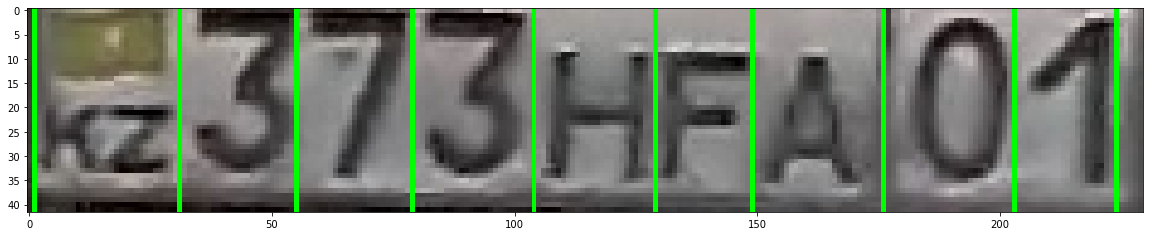

0 1 31 55 79 104 129 149 176 203 224 230
Dirty LPs/000018.jpg
268 964 302 1160
-1.5454545454545454


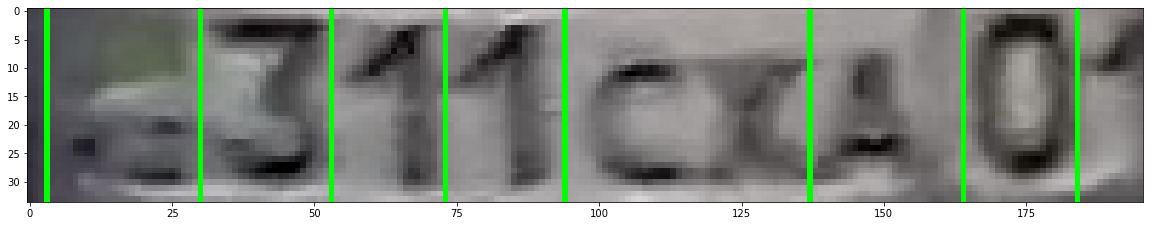

0 3 30 53 73 94 137 164 184 196
Dirty LPs/000030.jpg
382 660 420 874
-1.1818181818181819


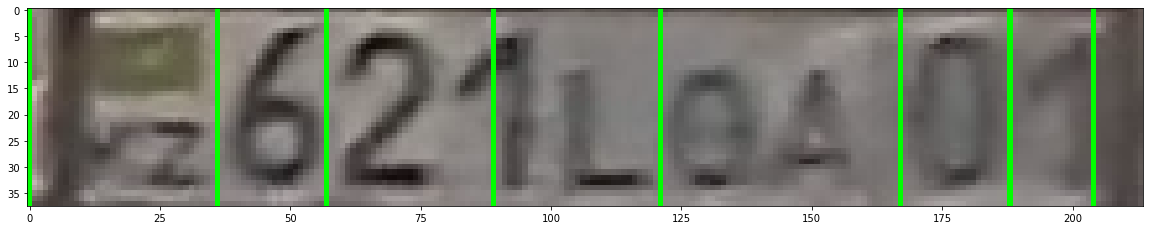

0 0 36 57 89 121 167 188 204 214
Dirty LPs/000042.jpg
416 202 454 468
-2.1818181818181817


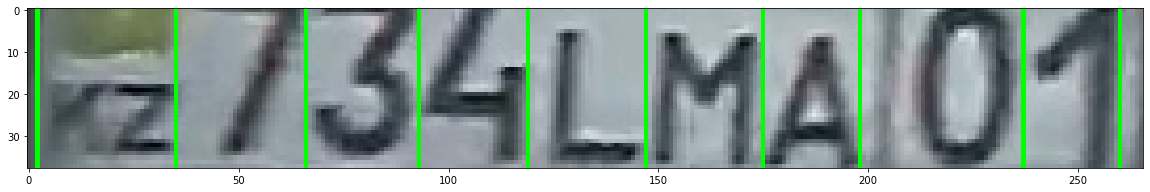

0 2 35 66 93 119 147 175 198 237 260 266
Dirty LPs/000048.jpg
480 230 514 448
-2.272727272727273


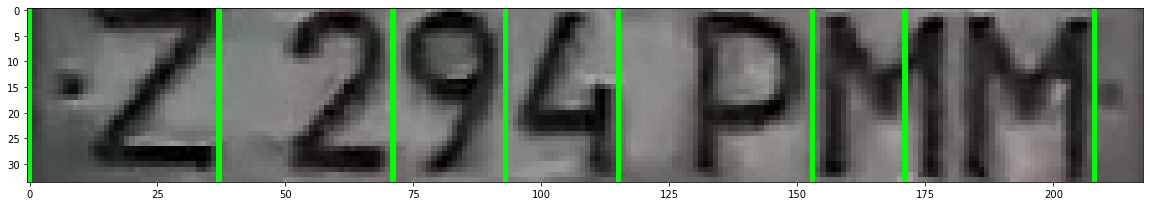

0 0 37 71 93 115 153 171 208 218
Dirty LPs/000072.jpg
472 354 516 572
-1.5454545454545454


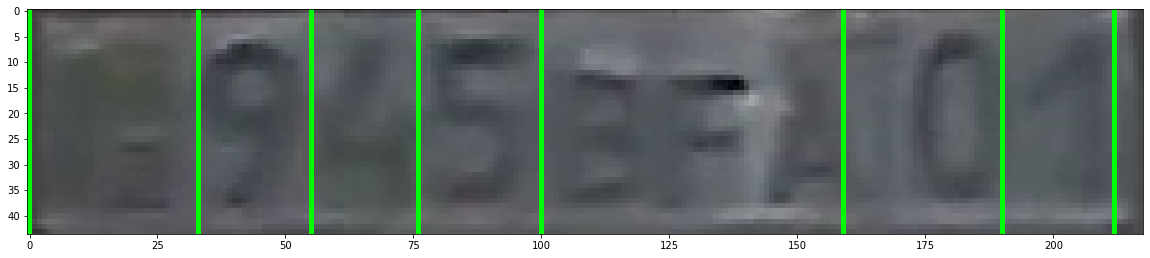

0 0 33 55 76 100 159 190 212 218
Dirty LPs/000078.jpg
578 1444 622 1732
-2.5454545454545454


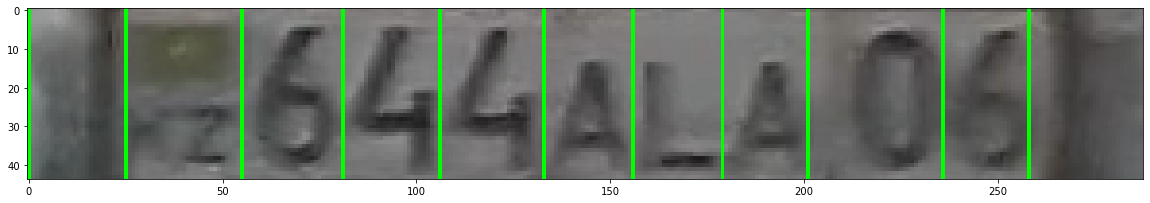

0 0 25 55 81 106 133 156 179 201 236 258 288
Dirty LPs/000090.jpg
384 318 424 518
-1.1818181818181819


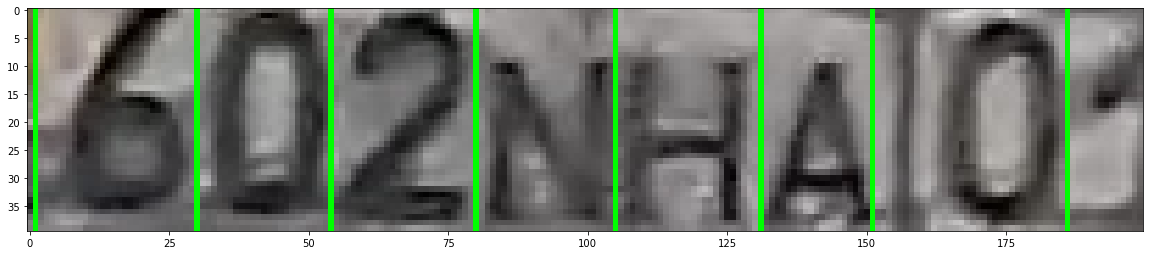

0 1 30 54 80 105 131 151 186 200
Dirty LPs/000091.jpg
530 556 566 784
-1.3636363636363635


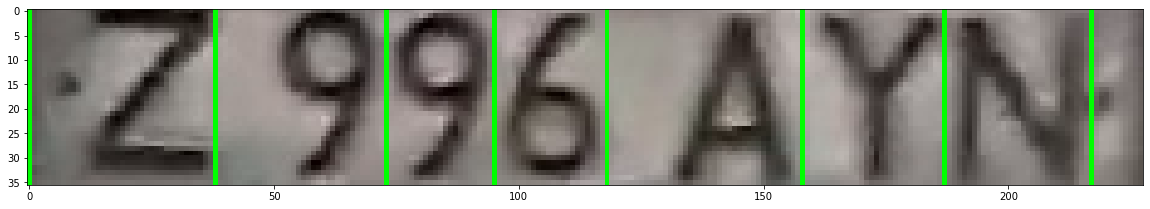

0 0 38 73 95 118 158 187 217 228
Dirty LPs/000104.jpg
222 98 254 254
-1.8181818181818183


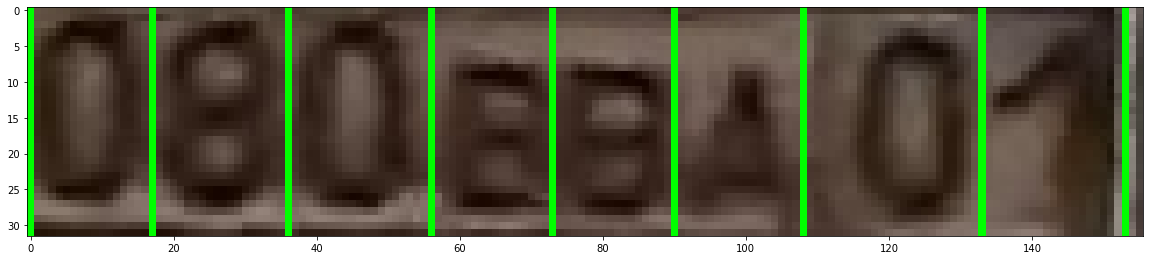

0 0 17 36 56 73 90 108 133 153 156
Dirty LPs/000129.jpg
536 1530 574 1762
-2.4545454545454546


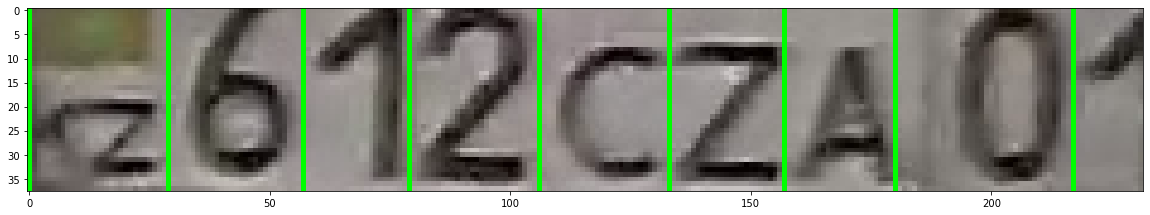

0 0 29 57 79 106 133 157 180 217 232
Dirty LPs/000132.jpg
620 214 656 454
-3.0


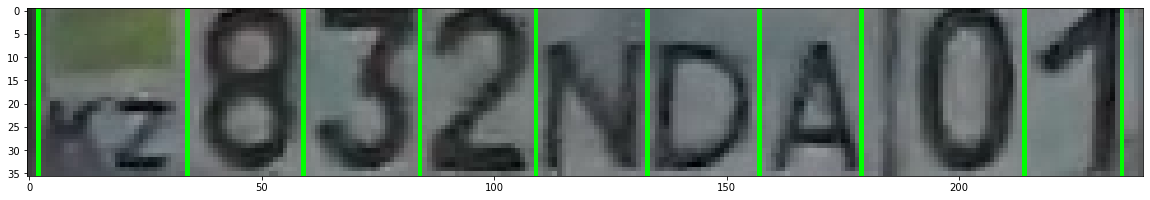

0 2 34 59 84 109 133 157 179 214 235 240
Dirty LPs/000140.jpg
872 902 914 1198
-2.3636363636363638


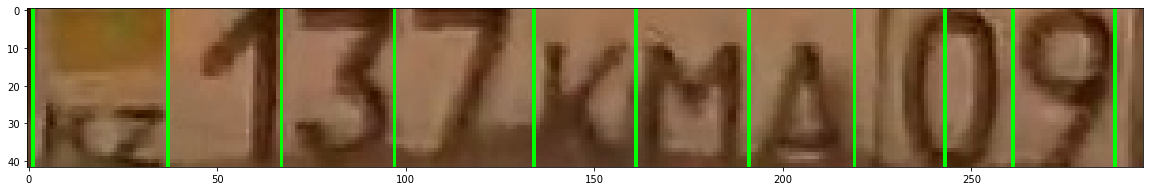

0 1 37 67 97 134 161 191 219 243 261 288 296
Dirty LPs/000157.jpg
518 228 558 500
-2.4545454545454546


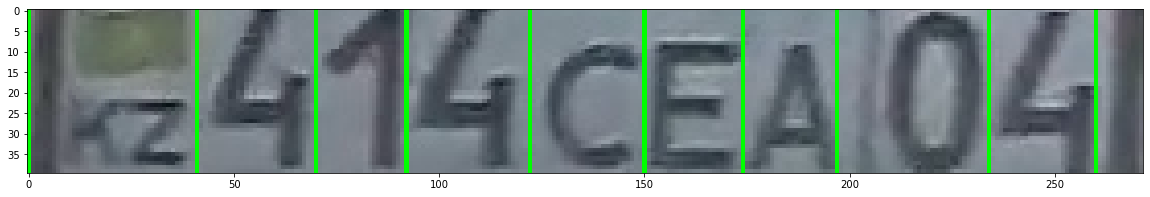

0 0 41 70 92 122 150 174 197 234 260 272
Dirty LPs/000174.jpg
314 226 344 406
-2.2727272727272725


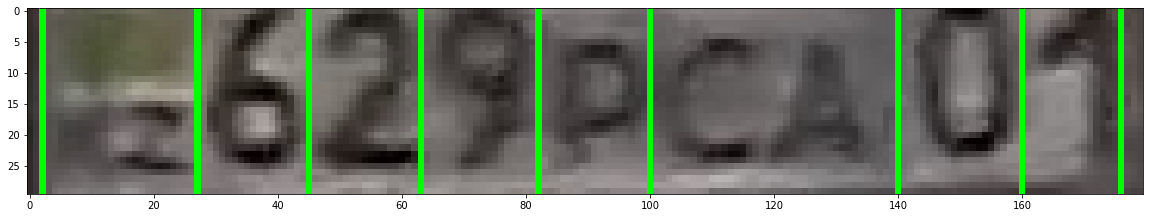

0 2 27 45 63 82 100 140 160 176 180
Dirty LPs/000180.jpg
806 1036 854 1404
-1.7272727272727275


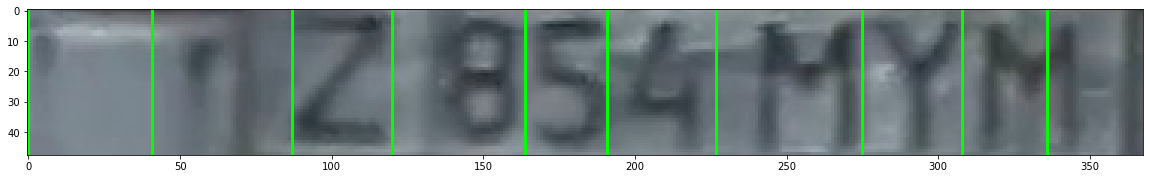

0 0 41 87 120 164 191 227 275 308 336 368
Dirty LPs/000184.jpg
284 222 316 410
-1.1818181818181817


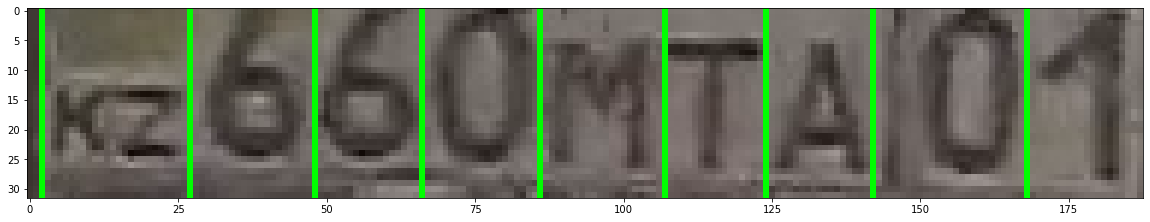

0 2 27 48 66 86 107 124 142 168 188
Dirty LPs/000188.jpg
642 472 690 752
-3.909090909090909


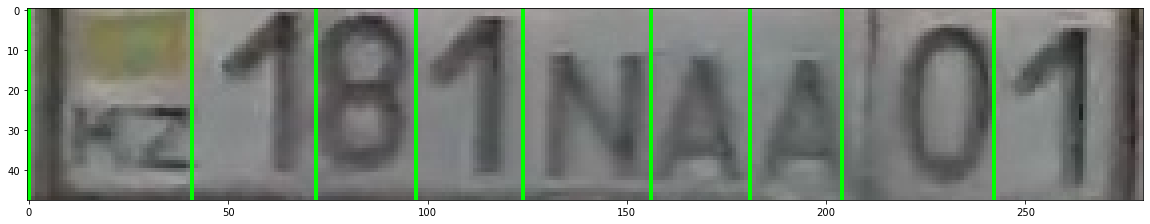

0 0 41 72 97 124 156 181 204 242 280
Dirty LPs/000202.jpg
820 806 872 1114
-3.7272727272727275


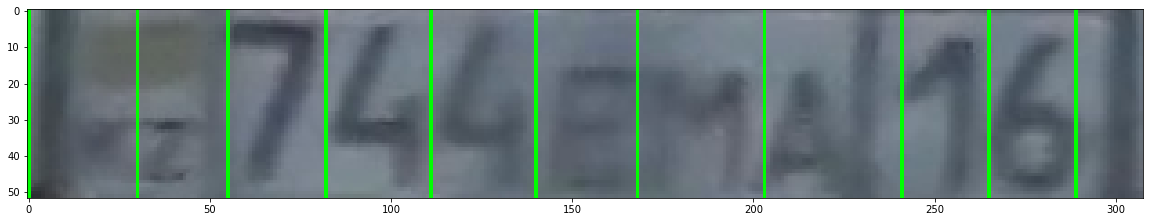

0 0 30 55 82 111 140 168 203 241 265 289 308
Dirty LPs/000208.jpg
800 804 848 1114
-1.9090909090909092


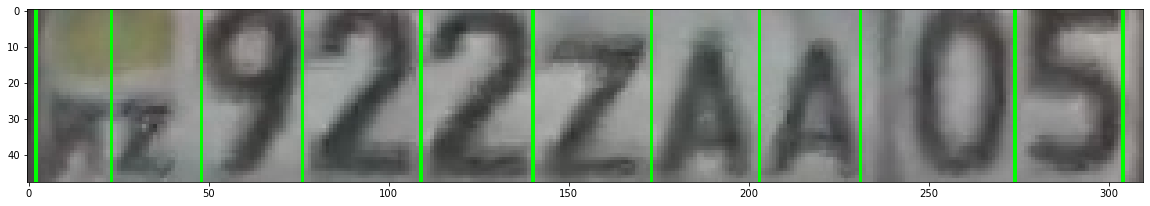

0 2 23 48 76 109 140 173 203 231 274 304 310
Dirty LPs/000216.jpg
622 304 662 550
-2.272727272727273


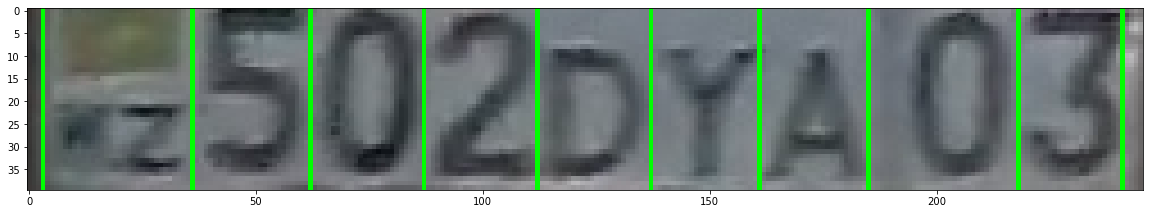

0 3 36 62 87 112 137 161 185 218 241 246
Dirty LPs/000227.jpg
478 602 516 794
-2.0


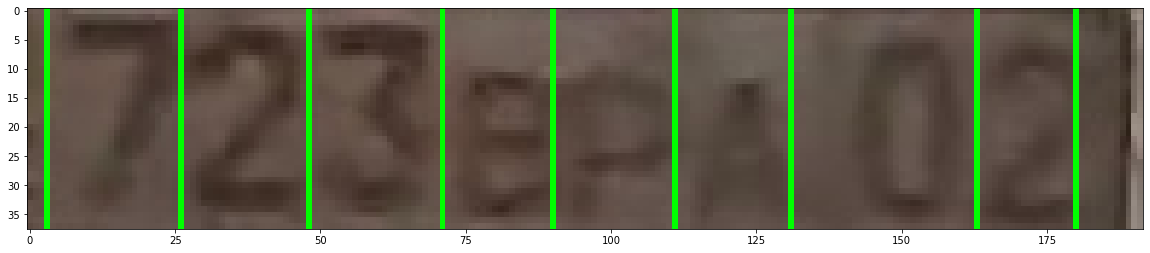

0 3 26 48 71 90 111 131 163 180 192
Dirty LPs/000229.jpg
390 274 422 486
-2.5454545454545454


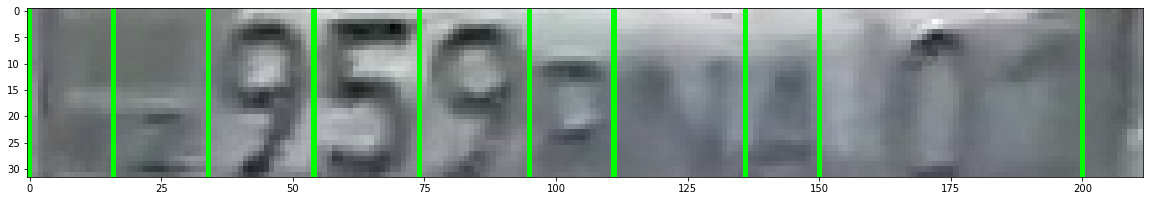

0 0 16 34 54 74 95 111 136 150 200 212
Dirty LPs/000236.jpg
586 578 632 842
-2.272727272727273


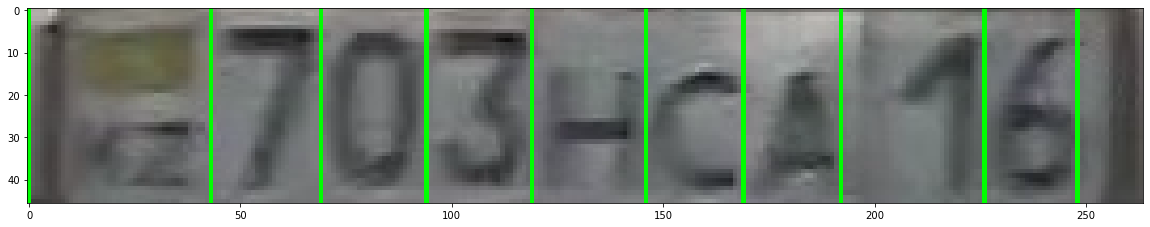

0 0 43 69 94 119 146 169 192 226 248 264
Dirty LPs/000265.jpg
502 412 546 690
-1.3636363636363635


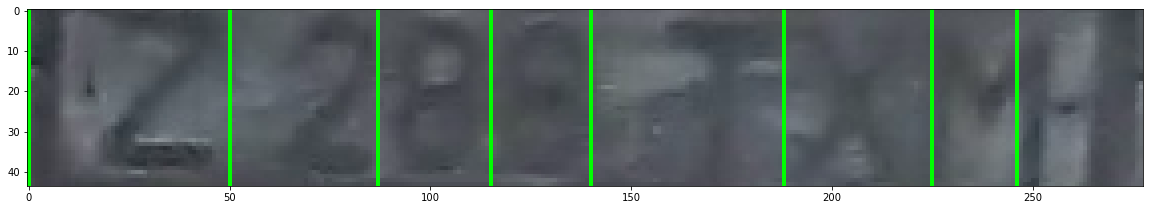

0 0 50 87 115 140 188 225 246 278
Dirty LPs/000267.jpg
292 298 320 472
-2.727272727272727


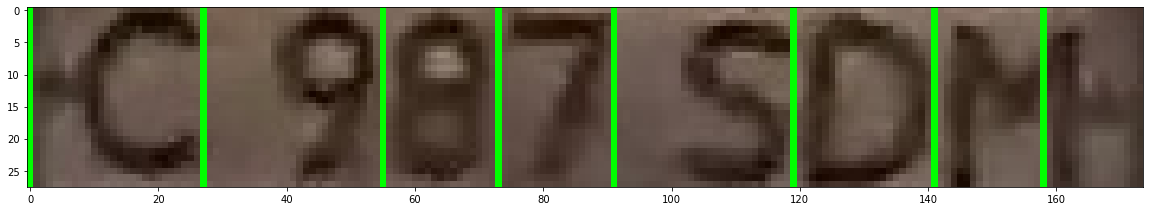

0 0 27 55 73 91 119 141 158 174
Dirty LPs/000282.jpg
648 492 684 758
-1.5454545454545454


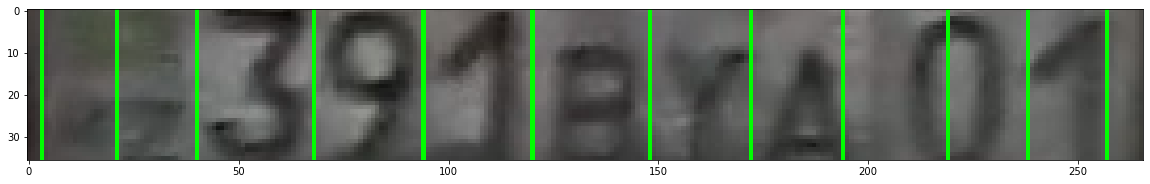

0 3 21 40 68 94 120 148 172 194 219 238 257 266
Dirty LPs/000283.jpg
716 1464 758 1728
-2.0


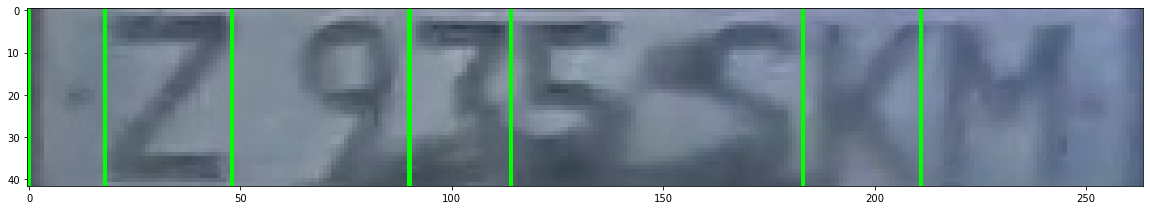

0 0 18 48 90 114 183 211 264
Dirty LPs/000306.jpg
590 86 640 336
-1.3636363636363635


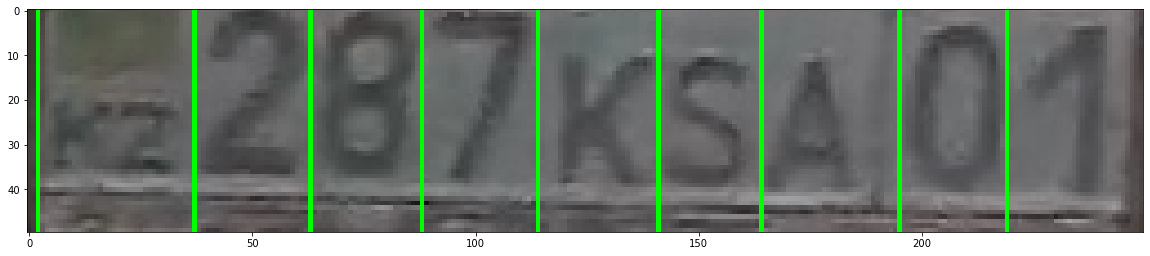

0 2 37 63 88 114 141 164 195 219 250
Dirty LPs/000307.jpg
262 942 296 1148
-1.4545454545454546


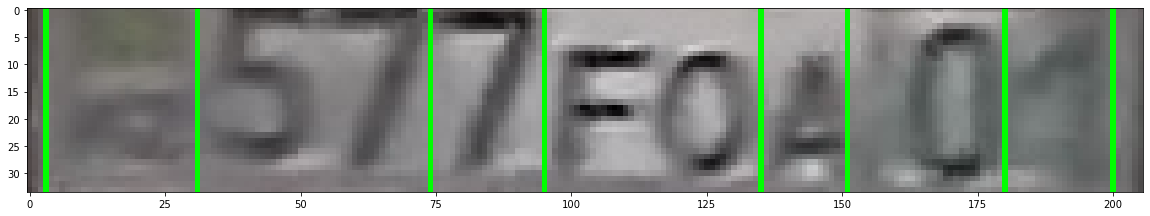

0 3 31 74 95 135 151 180 200 206
Dirty LPs/000323.jpg
646 512 684 766
-2.272727272727273


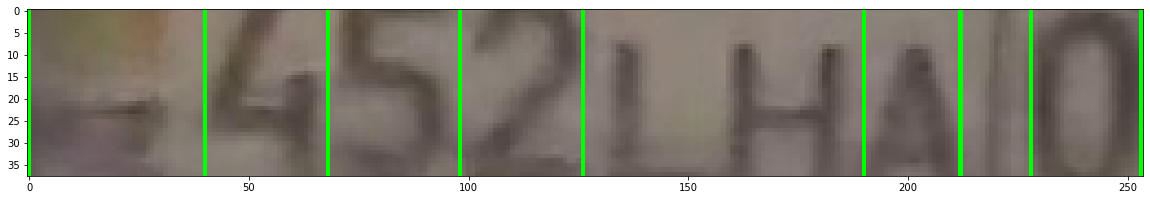

0 0 40 68 98 126 190 212 228 253 254
Dirty LPs/000330.jpg
760 1208 804 1524
-1.8181818181818183


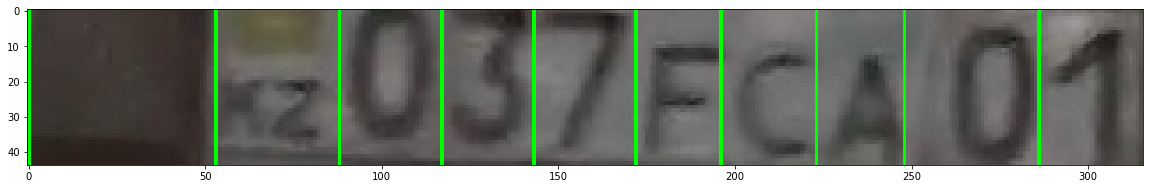

0 0 53 88 117 143 172 196 223 248 286 316
Dirty LPs/000335.jpg
356 506 392 706
-1.7272727272727273


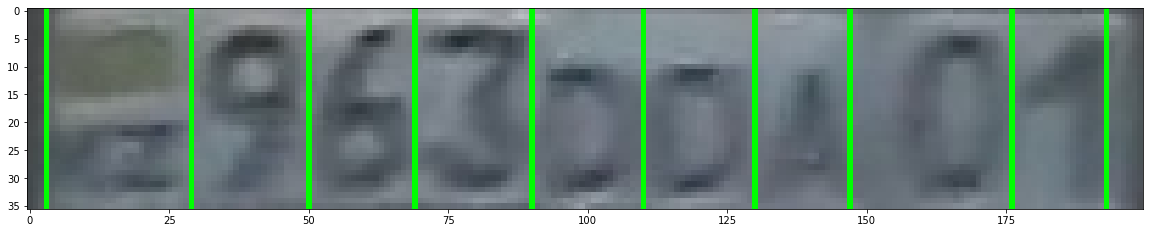

0 3 29 50 69 90 110 130 147 176 193 200
Dirty LPs/000342.jpg
612 156 652 390
-1.8181818181818183


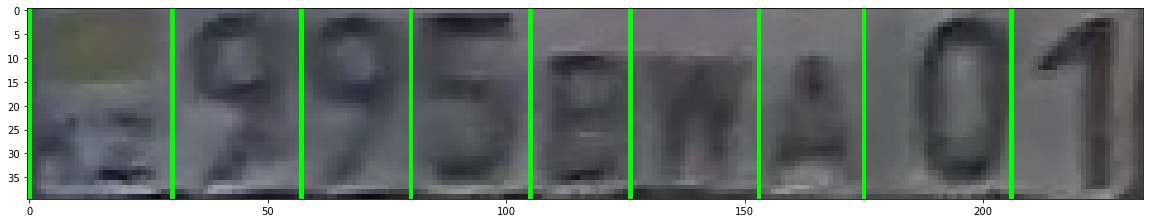

0 0 30 57 80 105 126 153 175 206 234
Dirty LPs/000350.jpg
640 1144 686 1418
-2.909090909090909


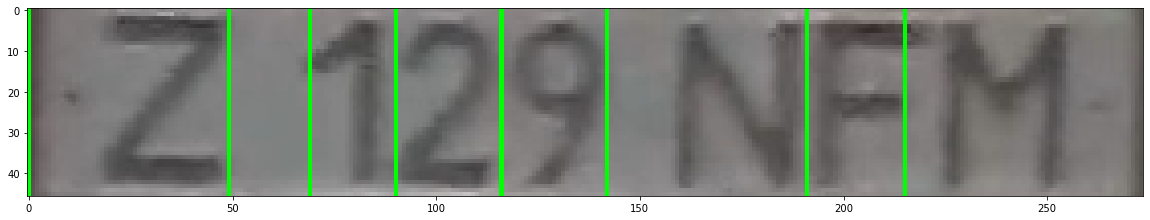

0 0 49 69 90 116 142 191 215 274
Dirty LPs/000370.jpg
644 1448 688 1710
-2.6363636363636367


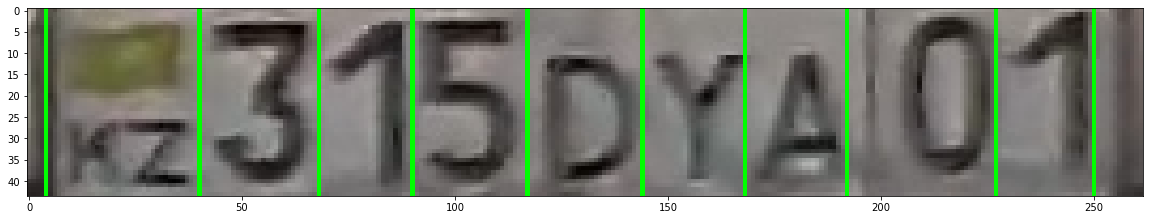

0 4 40 68 90 117 144 168 192 227 250 262
Dirty LPs/000386.jpg
536 144 574 414
-1.6363636363636365


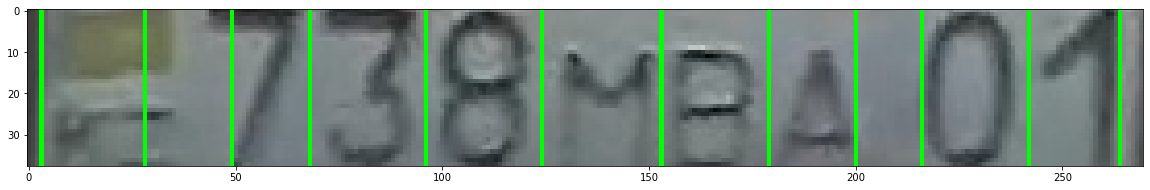

0 3 28 49 68 96 124 153 179 200 216 242 264 270
Dirty LPs/000387.jpg
362 30 398 268
-2.3636363636363638


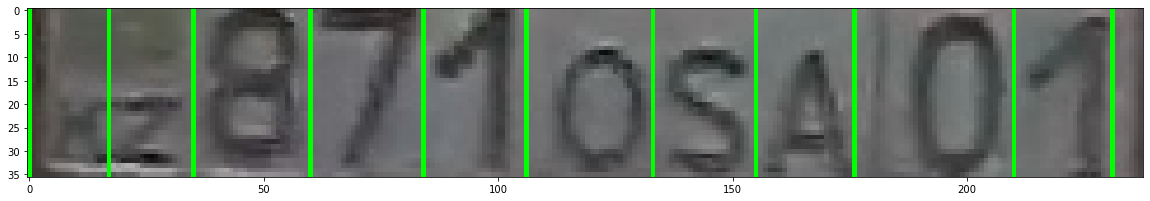

0 0 17 35 60 84 106 133 155 176 210 231 238
Dirty LPs/000388.jpg
340 1002 370 1192
-2.181818181818182


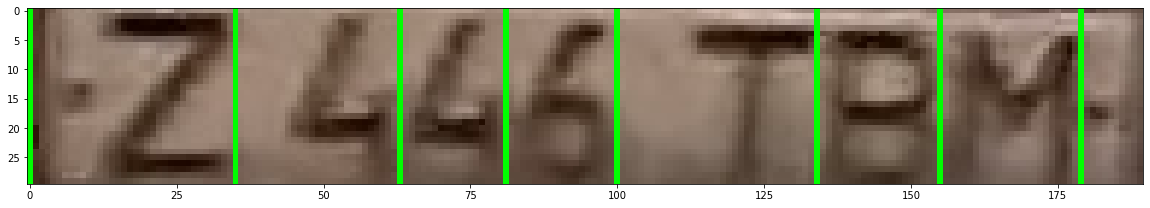

0 0 35 63 81 100 134 155 179 190
Dirty LPs/000390.jpg
330 504 366 714
-2.5454545454545454


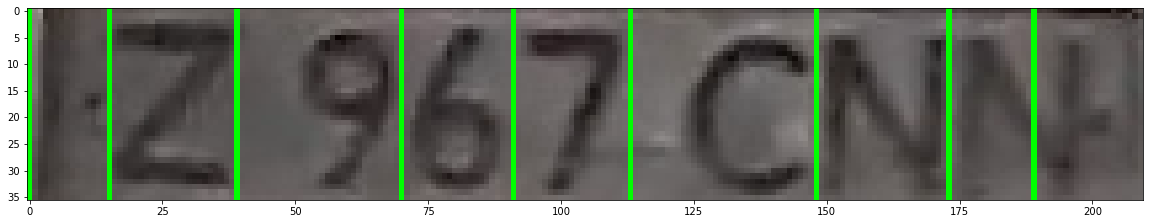

0 0 15 39 70 91 113 148 173 189 210
Dirty LPs/000404.jpg
954 612 1004 952
-2.4545454545454546


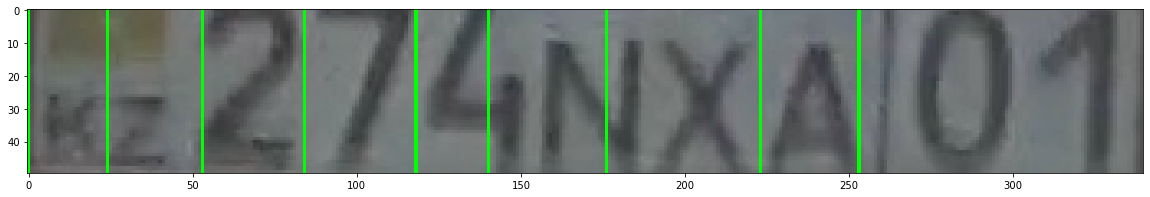

0 0 24 53 84 118 140 176 223 253 340
Dirty LPs/000408.jpg
498 176 540 404
-2.0


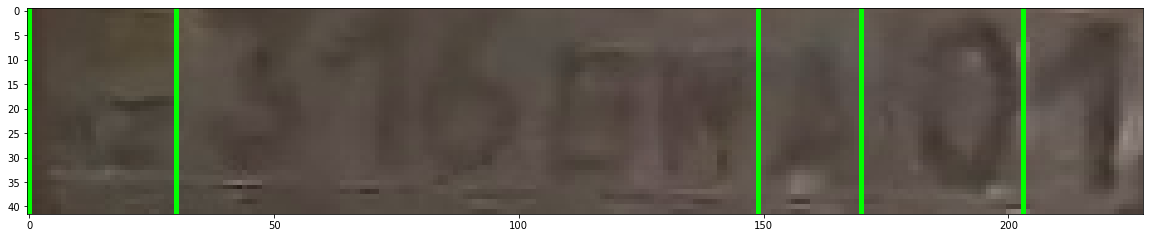

0 0 30 149 170 203 228
Dirty LPs/000414.jpg
526 2 564 282
-2.1818181818181817


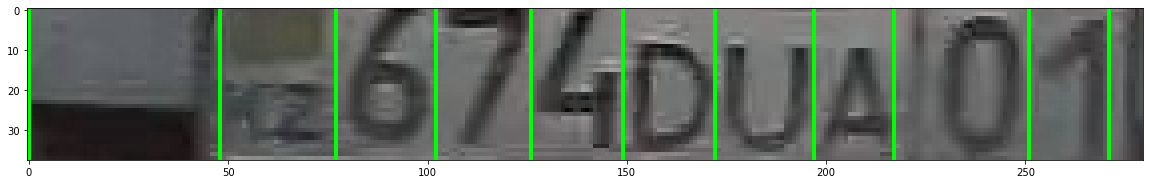

0 0 48 77 102 126 149 172 197 217 251 271 280
Dirty LPs/000415.jpg
720 448 768 756
-2.090909090909091


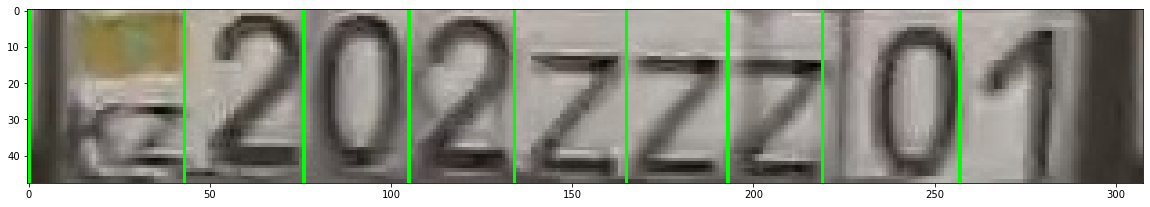

0 0 43 76 105 134 165 193 219 257 308
LPs big/000031.jpg
862 692 910 1024
-2.3636363636363638


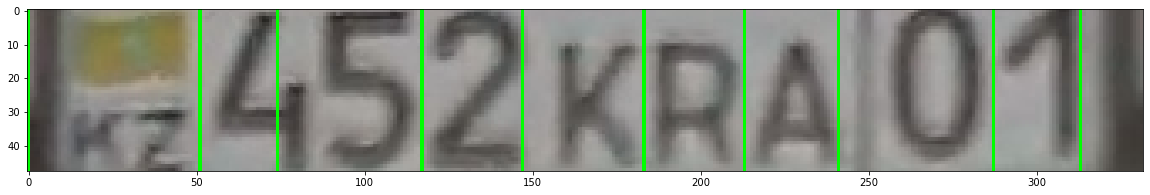

0 0 51 74 117 147 183 213 241 287 313 332
LPs big/000048.jpg
452 222 486 440
-2.272727272727273


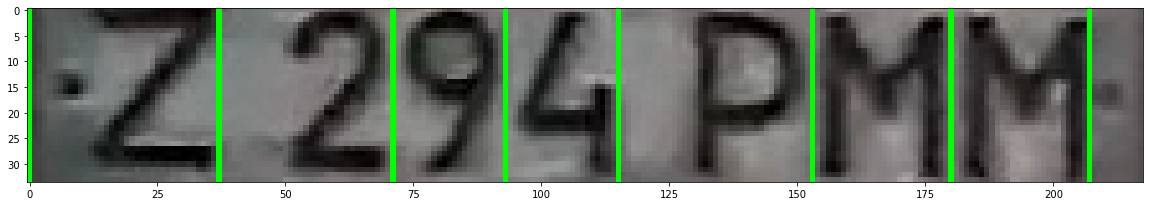

0 0 37 71 93 115 153 180 207 218
LPs big/000049.jpg
604 310 648 602
-2.4545454545454546


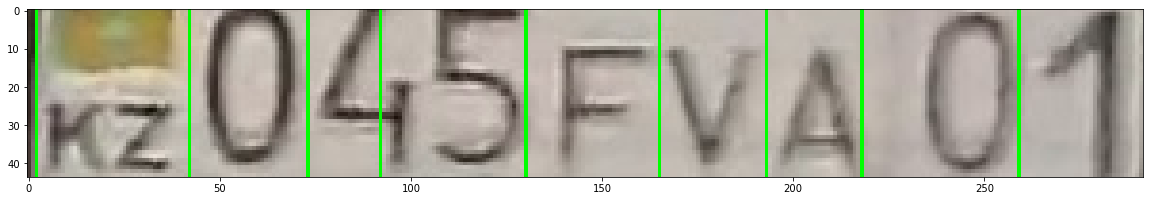

0 2 42 73 92 130 165 193 218 259 292
LPs big/000064.jpg
864 860 912 1176
-2.6363636363636367


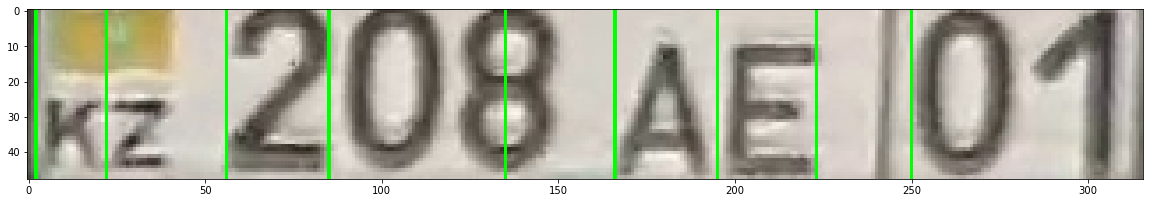

0 2 22 56 85 135 166 195 223 250 316
LPs big/000078.jpg
998 846 1046 1170
-2.1818181818181817


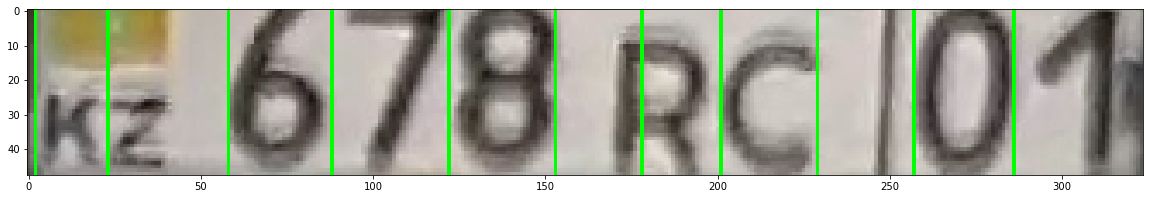

0 2 23 58 88 122 153 178 201 229 257 286 324
LPs big/000084.jpg
526 26 562 288
-1.6363636363636365


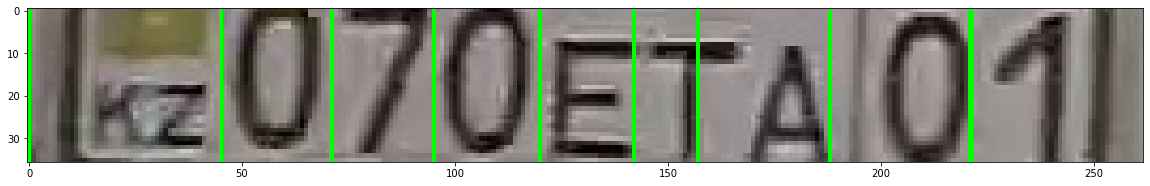

0 0 45 71 95 120 142 157 188 221 262
LPs big/000085.jpg
648 380 692 698
-3.272727272727273


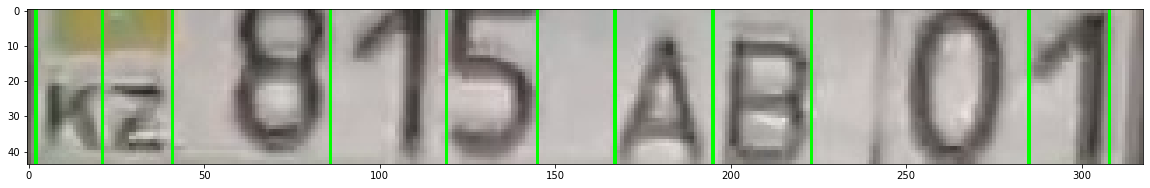

0 2 21 41 86 119 145 167 195 223 285 308 318
LPs big/000088.jpg
806 1176 856 1480
-3.1818181818181825


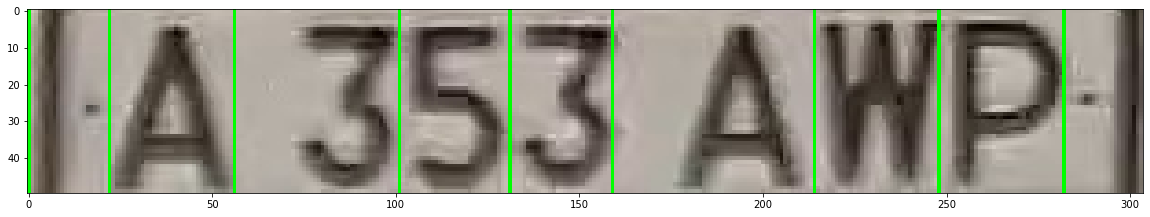

0 0 22 56 101 131 159 214 248 282 304
LPs big/000110.jpg
728 1174 776 1468
-3.272727272727273


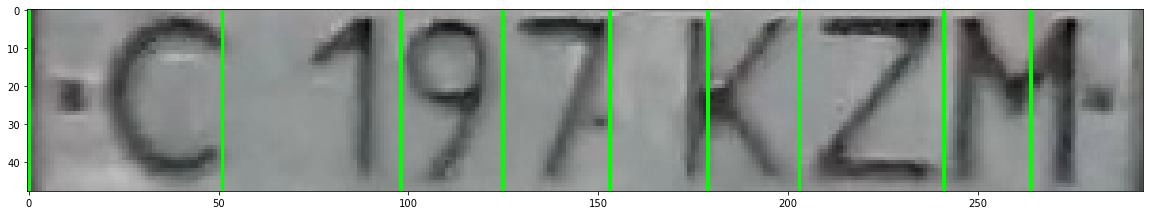

0 0 51 98 125 153 179 203 241 264 294
LPs big/000119.jpg
716 388 760 684
-3.8181818181818183


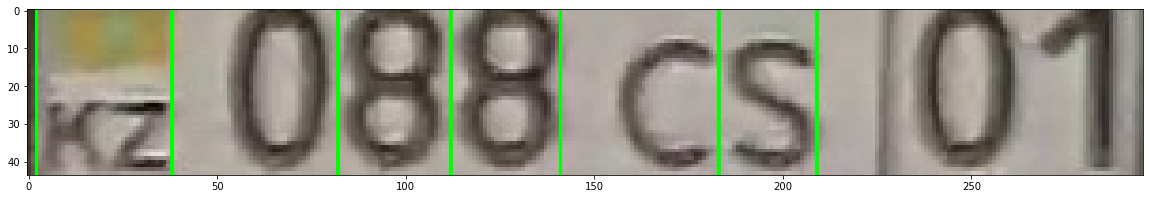

0 2 38 82 112 141 183 209 296
LPs big/000134.jpg
956 510 1006 860
-2.909090909090909


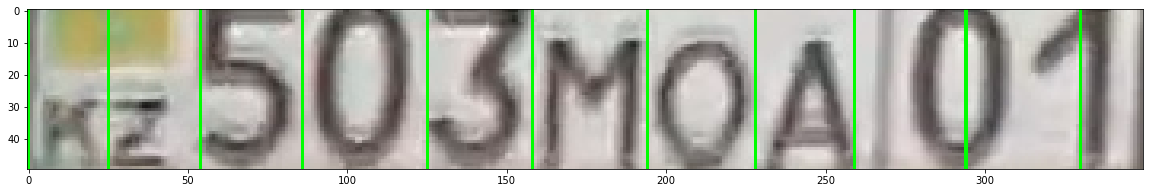

0 0 25 54 86 125 158 194 228 259 294 330 350
LPs big/000145.jpg
864 990 908 1290
-2.7272727272727275


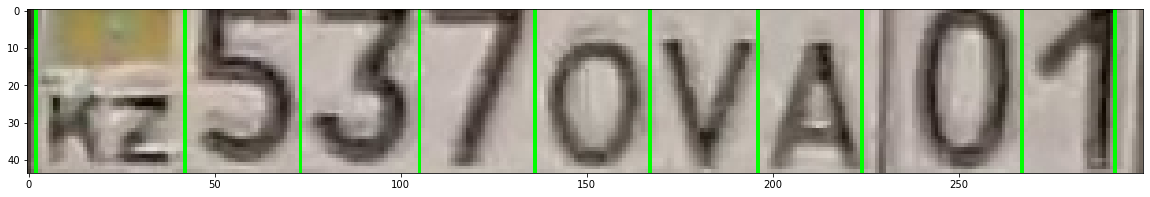

0 2 42 73 105 136 167 196 224 267 292 300
LPs big/000220.jpg
638 1370 682 1630
-2.0


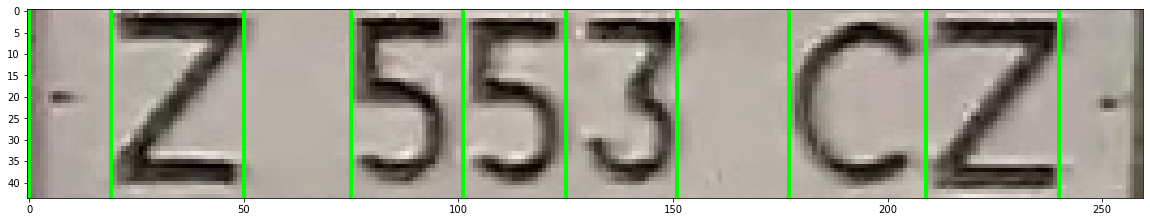

0 0 19 50 75 101 125 151 177 209 240 260
LPs big/000244.jpg
952 294 1006 668
-2.3636363636363638


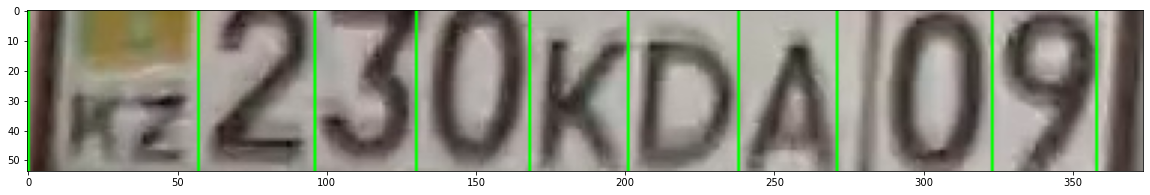

0 0 57 96 130 168 201 238 271 323 358 374
LPs big/000266.jpg
424 278 462 512
-2.4545454545454546


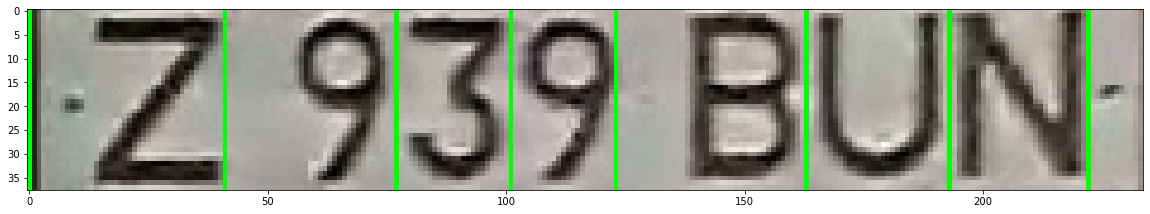

0 0 41 77 101 123 163 193 222 234
LPs big/000267.jpg
616 358 662 650
-3.0


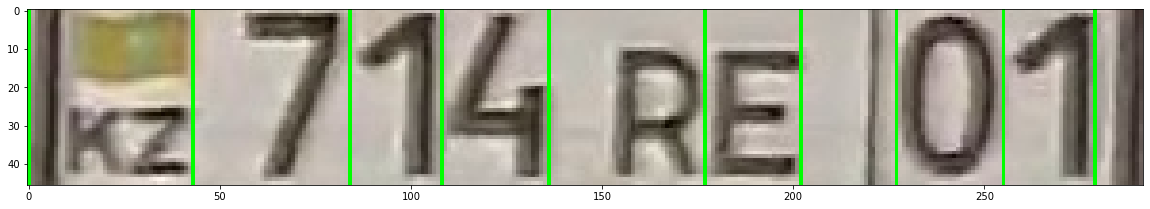

0 0 43 84 108 136 177 202 227 255 279 292
LPs big/000268.jpg
660 1268 704 1550
-1.9090909090909094


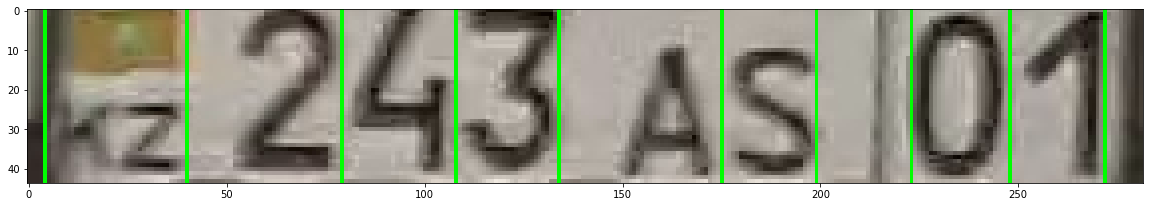

0 4 40 79 108 134 175 199 223 248 272 282
LPs big/000274.jpg
810 1182 856 1490
-2.0


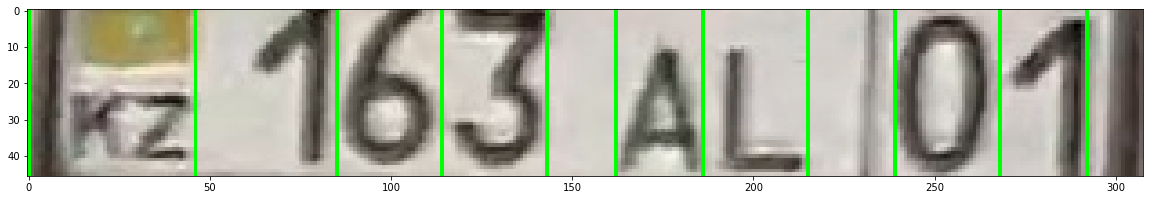

0 0 46 85 114 143 162 186 215 239 268 292 308
LPs big/000276.jpg
492 1192 538 1500
-2.7272727272727275


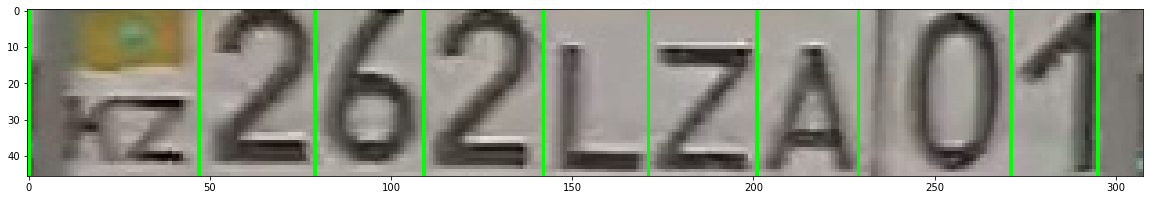

0 0 47 79 109 142 171 201 229 271 295 308
LPs big/000289.jpg
774 1078 818 1378
-2.7272727272727275


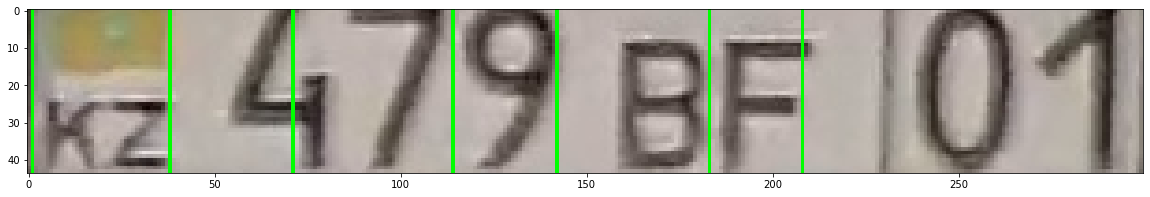

0 1 38 71 114 142 183 208 300
LPs big/000353.jpg
876 564 926 902
-1.5454545454545454


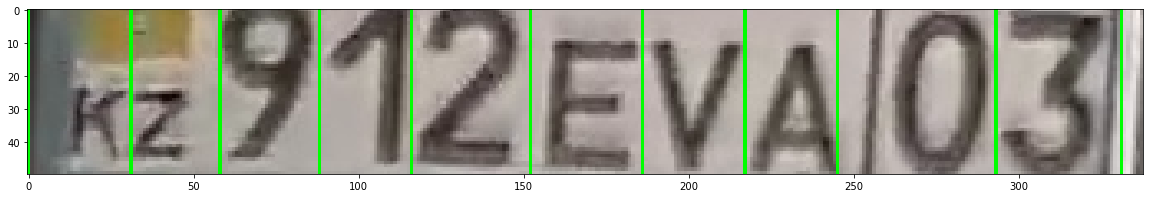

0 0 31 58 88 116 152 186 217 245 293 331 338
LPs big/000356.jpg
620 838 670 1180
-2.7272727272727275


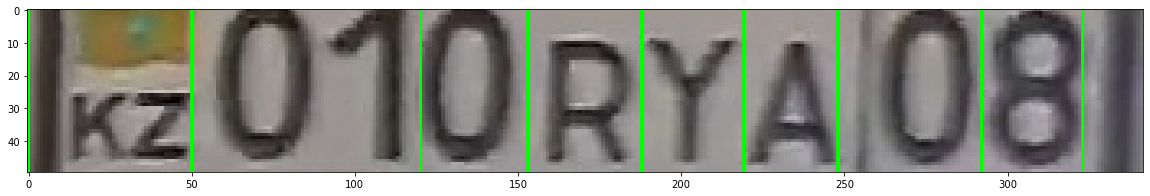

0 0 50 120 153 188 219 248 292 323 342
LPs big/000364.jpg
642 1048 684 1332
-1.8181818181818183


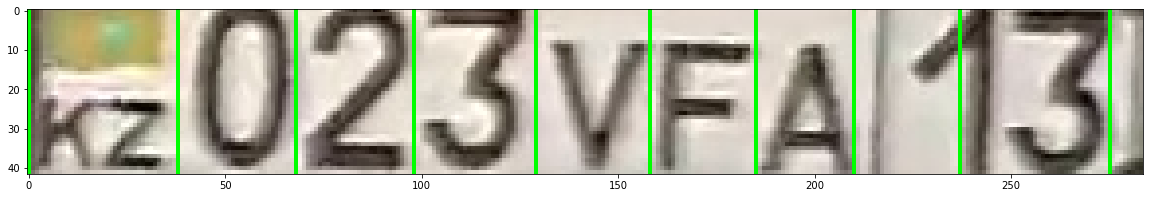

0 0 38 68 98 129 158 185 210 237 275 284
LPs big/000368.jpg
494 312 534 582
-3.7272727272727275


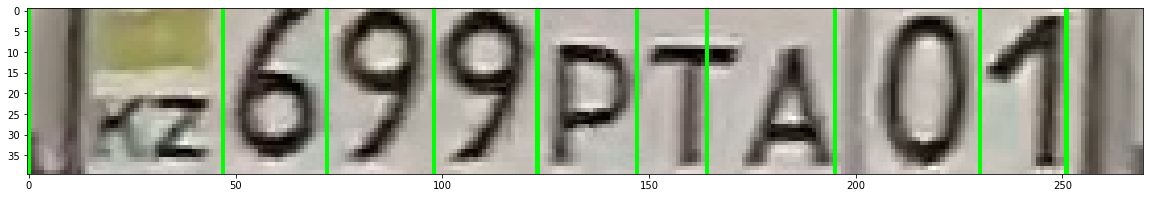

0 0 47 72 98 123 147 164 195 230 251 270
LPs big/000384.jpg
430 174 466 416
-2.1818181818181817


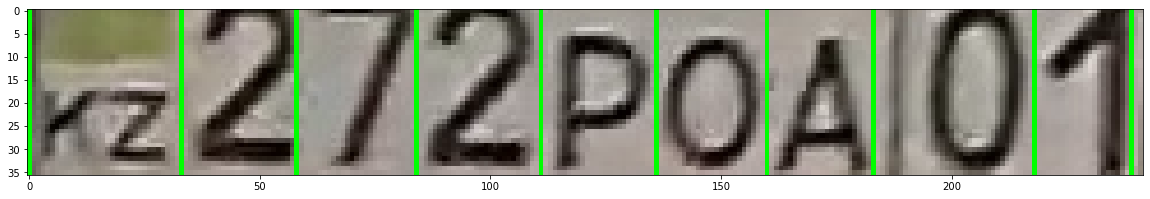

0 0 33 58 84 111 136 160 183 218 239 242
LPs big/000385.jpg
690 328 736 646
-2.4545454545454546


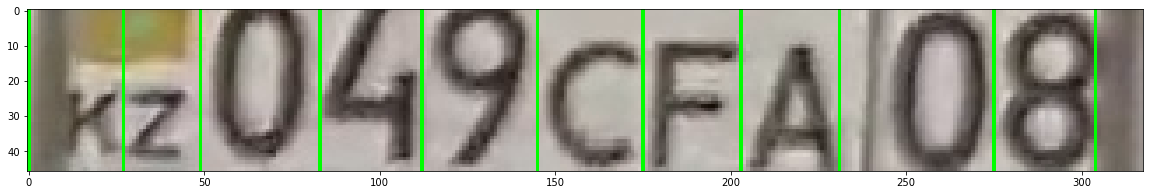

0 0 27 49 83 112 145 175 203 231 275 304 318
LPs big/000405.jpg
832 868 874 1166
-2.090909090909091


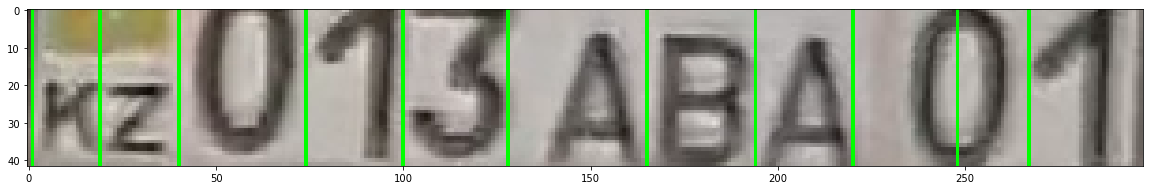

0 1 19 40 74 100 128 165 194 220 248 267 298
LPs big/000420.jpg
648 864 696 1164
-2.0


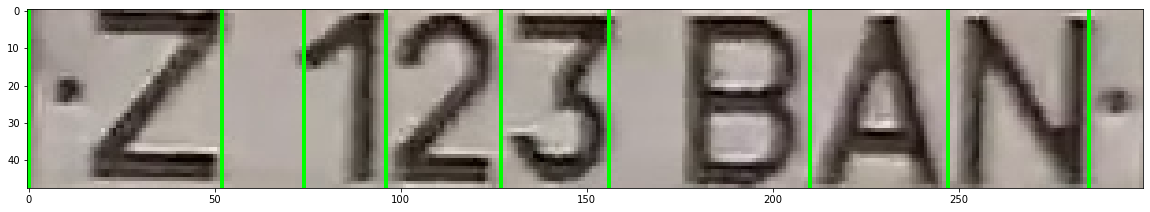

0 0 52 74 96 127 156 210 247 285 300
LPs big/000426.jpg
706 1166 748 1444
-2.090909090909091


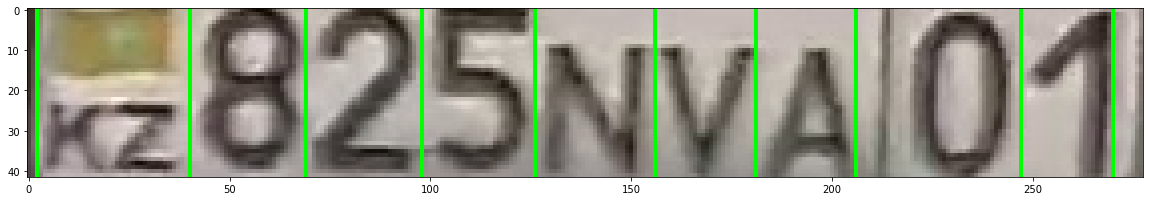

0 2 40 69 98 126 156 181 206 247 270 278
LPs big/000441.jpg
682 1484 726 1748
-2.5454545454545454


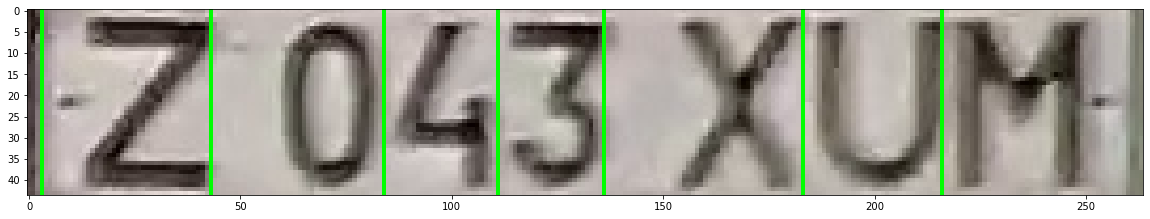

0 3 43 84 111 136 183 216 264
LPs big/000445.jpg
882 872 928 1182
-2.7272727272727275


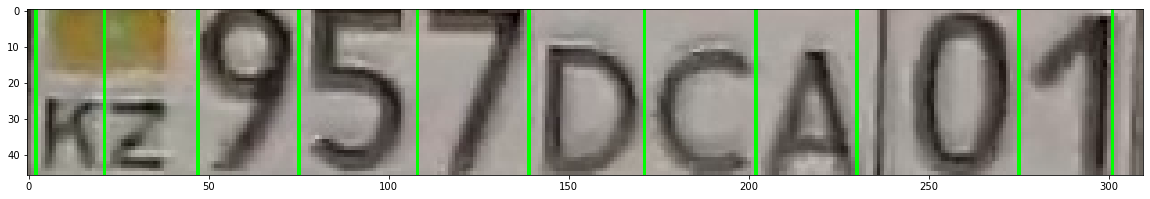

0 2 21 47 75 108 139 171 202 230 275 301 310
LPs big/000454.jpg
658 1352 700 1622
-3.909090909090909


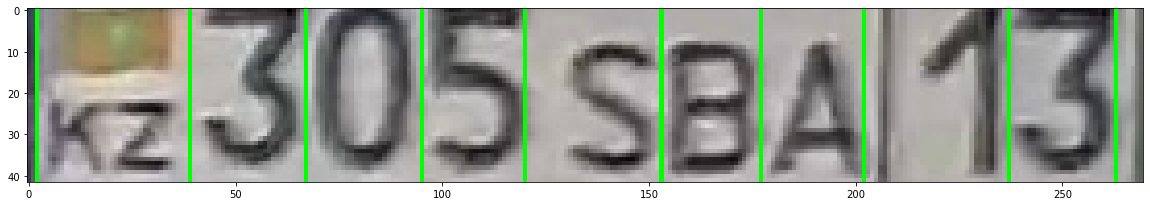

0 2 39 67 95 120 153 177 202 237 263 270
LPs big/000488.jpg
830 674 876 988
-3.8181818181818183


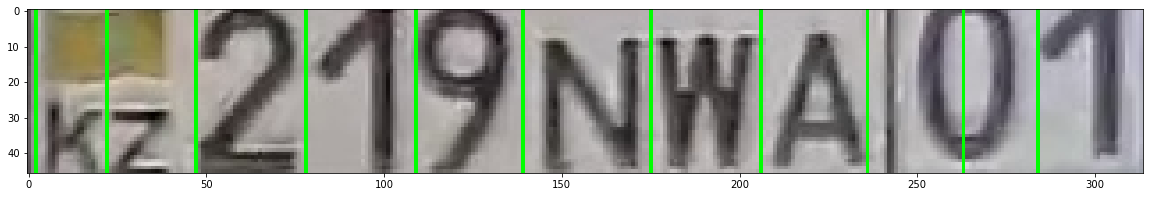

0 2 22 47 78 109 139 175 206 236 263 284 314
LPs big/000504.jpg
818 940 866 1256
-2.545454545454546


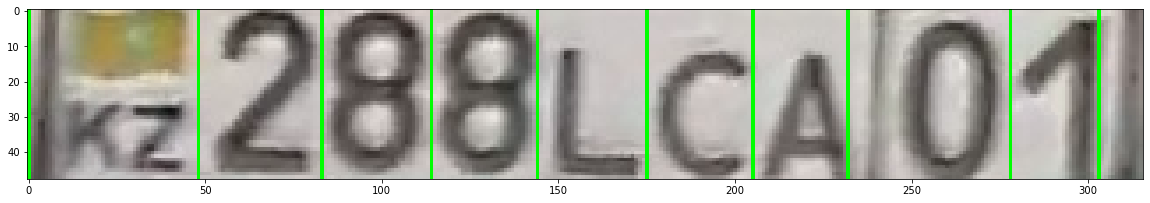

0 0 48 83 114 144 175 205 232 278 303 316
LPs big/000550.jpg
826 368 876 688
-2.454545454545454


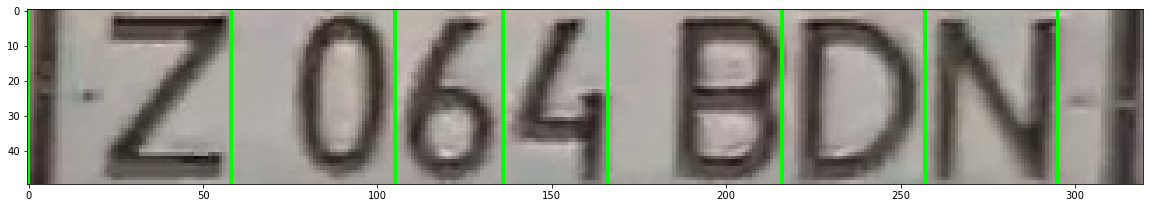

0 0 58 105 136 166 216 257 295 320
LPs big/000573.jpg
672 804 714 1106
-2.2727272727272734


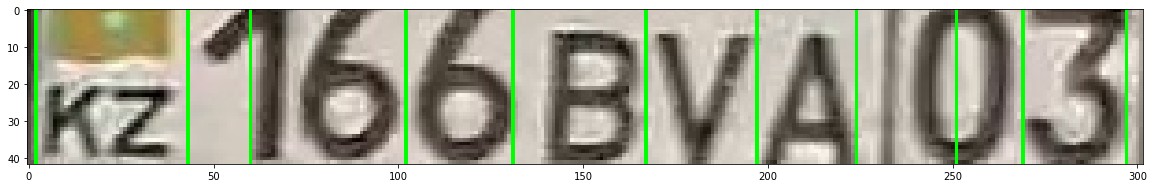

0 2 43 60 102 131 167 197 224 251 269 297 302
LPs big/000578.jpg
626 394 672 706
-3.0


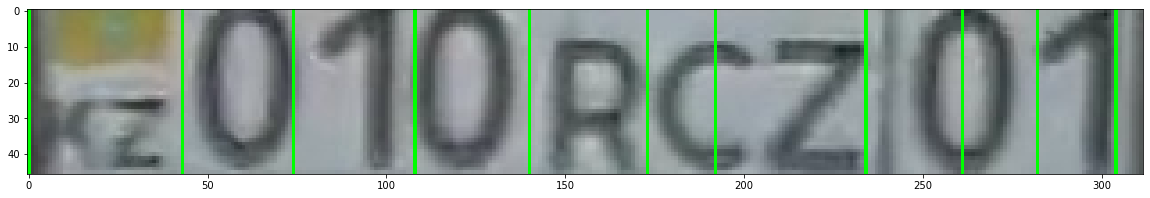

0 0 43 74 108 140 173 192 234 261 282 304 312
LPs big/000580.jpg
652 1116 694 1390
-3.5454545454545454


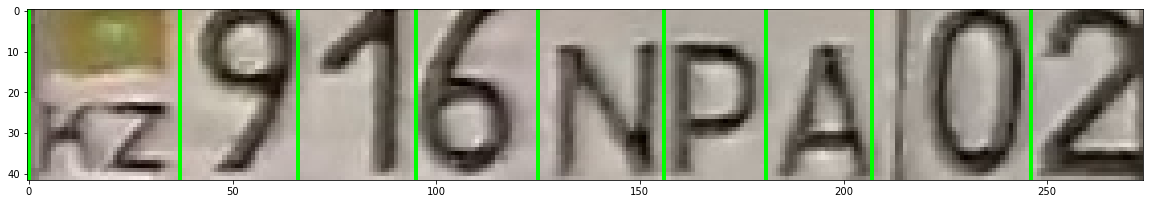

0 0 37 66 95 125 156 181 207 246 274 274
LPs big/000656.jpg
906 912 950 1234
-3.090909090909091


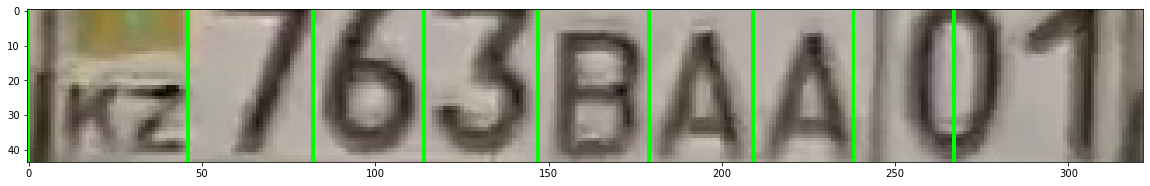

0 0 46 82 114 147 179 209 238 267 322
LPs big/000674.jpg
896 592 944 930
-2.090909090909091


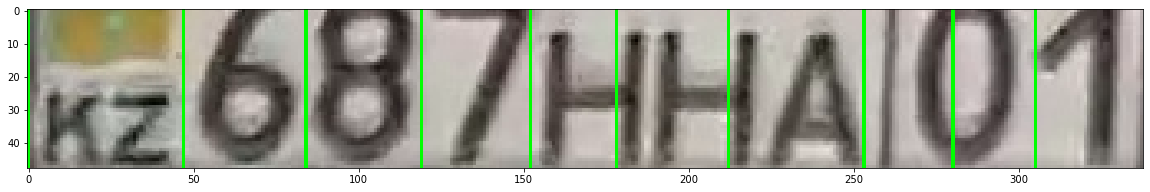

0 0 47 84 119 152 178 212 253 280 305 338
LPs big/000690.jpg
910 886 956 1206
-2.4545454545454546


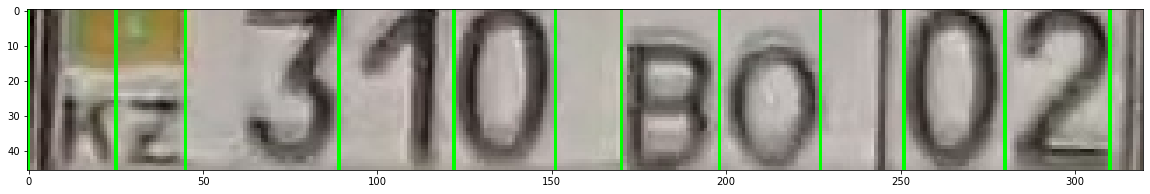

0 0 25 45 89 122 151 170 198 227 251 280 310 320
LPs big/000698.jpg
510 116 550 354
-2.6363636363636362


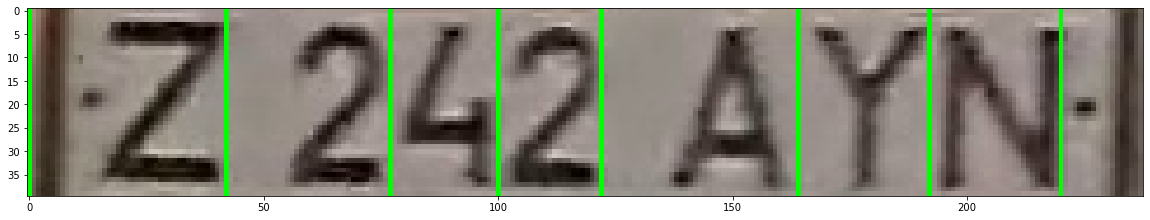

0 0 42 77 100 122 164 192 220 238
LPs big/000708.jpg
518 198 554 438
-1.9090909090909094


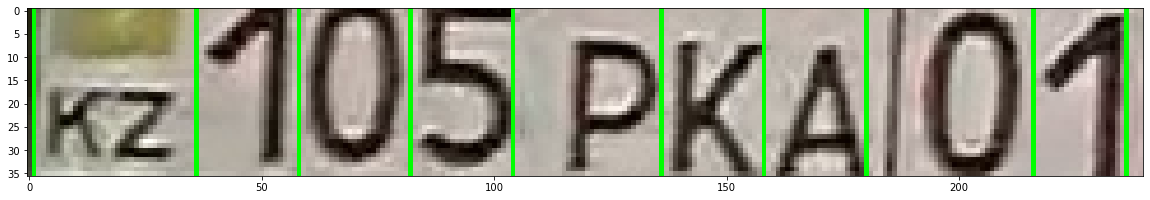

0 1 36 58 82 104 136 158 180 216 236 240
LPs big/000714.jpg
768 1150 812 1432
-2.8181818181818183


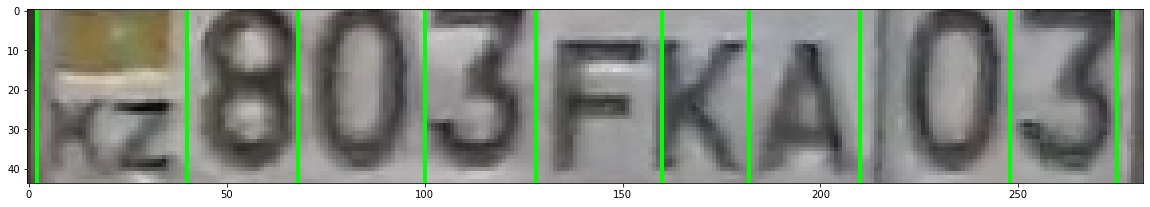

0 2 40 68 100 128 160 182 210 248 275 282
LPs big/000718.jpg
852 1044 896 1332
-1.7272727272727273


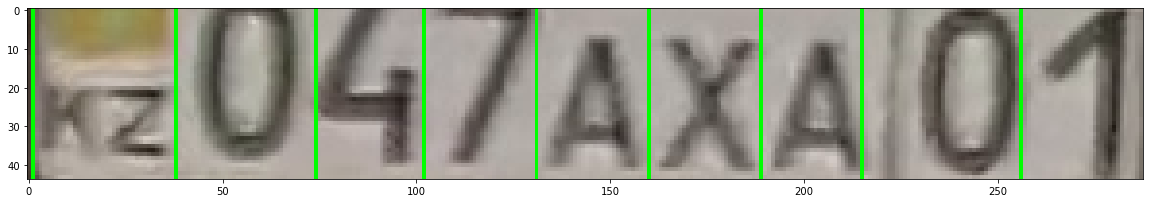

0 1 38 74 102 131 160 189 215 256 288
LPs big/000724.jpg
636 520 684 830
-2.0


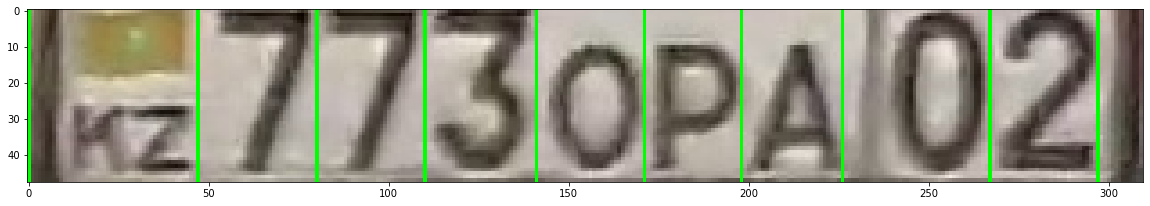

0 0 47 80 110 141 171 198 226 267 297 310
LPs big/000738.jpg
970 764 1014 1072
-3.0


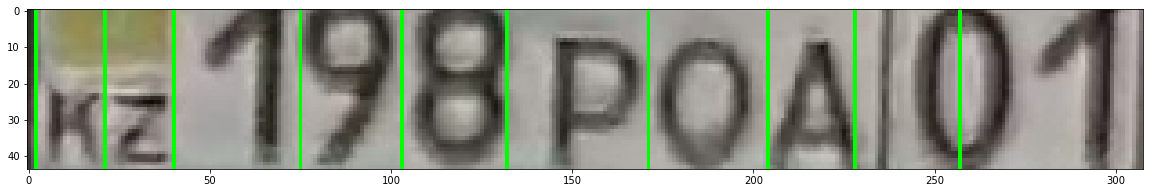

0 2 21 40 75 103 132 171 204 228 257 308
LPs big/000741.jpg
756 1182 802 1482
-2.6363636363636362


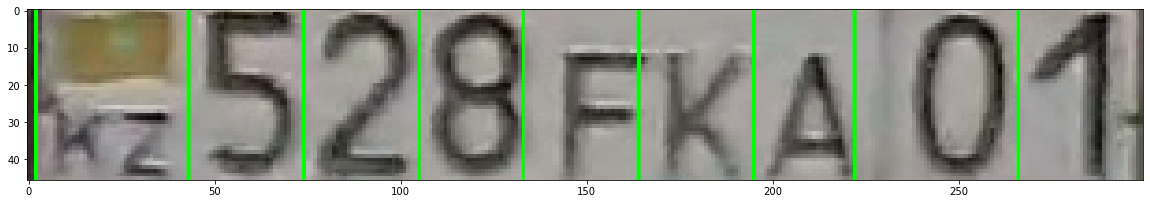

0 2 43 74 105 133 164 195 222 266 300
LPs big/000744.jpg
386 1420 428 1678
-3.454545454545455


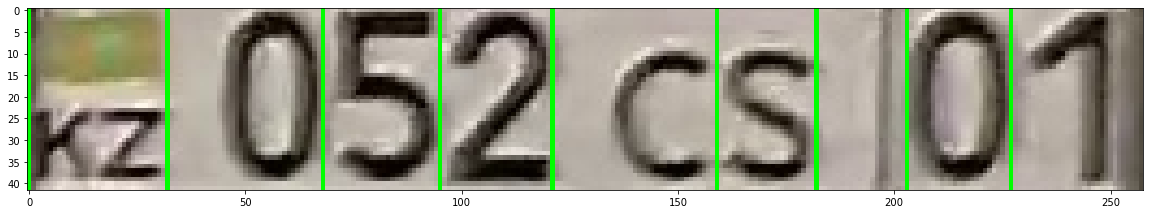

0 0 32 68 95 121 159 182 203 227 258
LPs big/000754.jpg
656 1456 700 1736
-2.7272727272727275


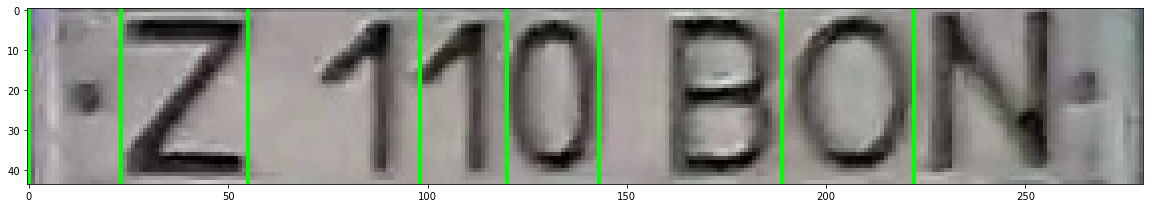

0 0 23 55 98 120 143 189 222 280


In [29]:
for i in range(len(imageColFin)):
    name = datasetInfoFin[i]
    print(name[0])
    print(' '.join(name[1]))
    ans = horizontal_segmentation(imageColFin[i])
    print(*ans)
    j += 1

In [30]:
j

94